# **Legal Text Classifier Model Training Notebook**

In [ ]:
!pip uninstall torchvision

Found existing installation: torchvision 0.22.0+cu118
Uninstalling torchvision-0.22.0+cu118:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/torchvision-0.22.0+cu118.dist-info/*
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libcudart.60cfec8e.so.11.0
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libjpeg.c0b0716f.so.8
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libnvjpeg.70530407.so.11
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libpng16.41d77625.so.16
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libsharpyuv.d7dafb46.so.0
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libwebp.ad67f466.so.7
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libz.f537e57c.so.1
    /usr/local/lib/python3.11/dist-packages/torchvision/*
Proceed (Y/n)? Y
  Successfully uninstalled torchvision-0.22.0+cu118


In [ ]:
!pip install torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.0%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.0%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl (6.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0+cu118 which is incompatible.


***This will install PyTorch with CUDA 11.8. You should replace 'cu118' with the specific CUDA version if you need a different one.***

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
GPU Name: NVIDIA A100-SXM4-40GB


In [ ]:
!nvidia-smi
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

Sat May  3 20:27:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             47W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# ✅ Step 1: Install dependencies
!pip install -q transformers datasets evaluate scikit-learn

In [ ]:
# ✅ Step 2: Imports
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
# ✅ Step 3: Load LEDGAR dataset (via HuggingFace)
dataset = load_dataset("lex_glue", "ledgar")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.31M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# ✅ Step 4: Define labels
labels = dataset["train"].features["label"].names
num_labels = len(labels)

In [ ]:
# ✅ Step 5: Tokenize
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

In [ ]:
tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# ✅ Step 6: Load model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ✅ Step 7: Define metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
    }

In [ ]:
!pip install --upgrade transformers

In [ ]:
# ✅ Step 8: Training setup
training_args = TrainingArguments(
    output_dir="ledgar_roberta_finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [ ]:
# ✅ Step 9: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-19-74f554042309>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# ✅ Step 10: Train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chaospathfinder859 (chaospathfinder859-nsbm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=11250, training_loss=0.7406294053819444, metrics={'train_runtime': 2316.6721, 'train_samples_per_second': 77.698, 'train_steps_per_second': 4.856, 'total_flos': 2.370083106816e+16, 'train_loss': 0.7406294053819444, 'epoch': 3.0})

In [ ]:
# ✅ Step 11: Evaluate
eval_results = trainer.evaluate(tokenized_dataset["test"])
print("Test results:", eval_results)

Test results: {'eval_loss': 0.565356433391571, 'eval_accuracy': 0.8583, 'eval_f1': 0.7611737907267566, 'eval_runtime': 34.3014, 'eval_samples_per_second': 291.533, 'eval_steps_per_second': 18.221, 'epoch': 3.0}


In [ ]:
# ✅ Step 12: Save model for download
import shutil
model.save_pretrained("ledgar_roberta_finetuned")
tokenizer.save_pretrained("ledgar_roberta_finetuned")
shutil.make_archive("ledgar_roberta_finetuned", 'zip', "ledgar_roberta_finetuned")

'/content/ledgar_roberta_finetuned.zip'

In [ ]:
from google.colab import files
files.download("ledgar_roberta_finetuned.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Hyperparmeter Tuning**

In [ ]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 MB 35.3 MB/s eta 0:00:00


In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from ray import tune
import evaluate
import numpy as np
from sklearn.metrics import classification_report
import gc


# Define the model_init function inside the hyperparameter search loop
# to avoid serialization issues.
def objective(config):
    # Load the model and tokenizer within the objective function.
    model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base", num_labels=num_labels
    )
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")

    # Define the compute_metrics function within the objective function.
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = evaluate.load("accuracy")
        f1 = evaluate.load("f1")

        return {
            "accuracy": accuracy.compute(predictions=predictions, references=labels)[
                "accuracy"
            ],
            "f1": f1.compute(
                predictions=predictions, references=labels, average="macro"
            )["f1"],
        }

    # Define TrainingArguments within the objective function.
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=config["learning_rate"],
        #per_device_train_batch_size=config["per_device_train_batch_size"],
        per_device_train_batch_size=8,  # Reduced batch size
        per_device_eval_batch_size=8,  # Reduced batch size
        gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
        num_train_epochs=config["num_train_epochs"],
        weight_decay=0.01,
        report_to="none",  # Disable logging
    )

    # Define Trainer within the objective function.
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    # Train the model and return the evaluation results.
    results = trainer.train()
    eval_results = trainer.evaluate(tokenized_dataset["test"])

    # Return the metric to optimize (e.g., accuracy).
    return eval_results["eval_accuracy"]  # or eval_results["eval_f1"]

# Define the search space using Ray Tune.
search_space = {
    "learning_rate": tune.choice([1e-5, 2e-5, 3e-5]),
    "num_train_epochs": tune.choice([3, 4, 5]),
    "per_device_train_batch_size": tune.choice([16, 32]),
}

# Run the hyperparameter search using Ray Tune.
# The 'direction' argument has been replaced with 'mode'.
# The 'num_cpus_per_trial' argument has been replaced with 'resources_per_trial={"cpu": 1}'.
analysis = tune.run(
    objective,  # Pass the objective function
    config=search_space,
    num_samples=5,  # Number of trials
    mode="max",  # Optimize for maximum accuracy (or f1) # Changed from 'direction' to 'mode'
    resources_per_trial={"cpu": 1, "gpu": 1},  # Limit to 1 CPU per trial # Changed from 'num_cpus_per_trial' to 'resources_per_trial'
)

# Get the best hyperparameters and results.
best_config = analysis.get_best_config(metric="eval_accuracy", mode="max")
best_result = analysis.get_best_trial(metric="eval_accuracy", mode="max").last_result

print("Best Hyperparameters:", best_config)
print("Best Accuracy:", best_result["eval_accuracy"])  # or best_result["eval_f1"]

2025-05-03 23:17:09,663	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+------------------------------------------------------------------+
| Configuration for experiment     objective_2025-05-03_23-17-09   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        FIFOScheduler                   |
| Number of trials                 5                               |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/objective_2025-05-03_23-17-09

Trial status: 5 PENDING
Current time: 2025-05-03 23:17:09. Total running time: 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------

(pid=55562) 2025-05-03 23:17:16.092638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=55562) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=55562) E0000 00:00:1746314236.116028   55562 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=55562) E0000 00:00:1746314236.122625   55562 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Trial objective_bcc1f_00000 started with configuration:
+----------------------------------------------+
| Trial objective_bcc1f_00000 config           |
+----------------------------------------------+
| learning_rate                          1e-05 |
| num_train_epochs                           3 |
| per_device_train_batch_size               16 |
+----------------------------------------------+


(objective pid=55562) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(objective pid=55562) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(objective pid=55562) <ipython-input-32-c24bf740dd1d>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  1%|          | 106/11250 [00:19<32:14,  5.76it/s]



Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:17:39. Total running time: 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+---------------

  2%|▏         | 280/11250 [00:50<31:54,  5.73it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:18:10. Total running time: 1min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+------------

  4%|▍         | 452/11250 [01:19<31:13,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:18:40. Total running time: 1min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

  4%|▍         | 500/11250 [01:28<31:06,  5.76it/s]


(objective pid=55562) {'loss': 3.2787, 'grad_norm': 12.091130256652832, 'learning_rate': 9.556444444444445e-06, 'epoch': 0.13}


  6%|▌         | 626/11250 [01:50<30:40,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:19:10. Total running time: 2min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+------------

  7%|▋         | 799/11250 [02:20<30:22,  5.73it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:19:40. Total running time: 2min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

  9%|▊         | 972/11250 [02:50<29:38,  5.78it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:20:10. Total running time: 3min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+------------

  9%|▉         | 1000/11250 [02:55<29:36,  5.77it/s]


(objective pid=55562) {'loss': 1.8957, 'grad_norm': 10.989901542663574, 'learning_rate': 9.112e-06, 'epoch': 0.27}


 10%|█         | 1146/11250 [03:20<29:13,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:20:40. Total running time: 3min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 12%|█▏        | 1319/11250 [03:50<28:43,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:21:10. Total running time: 4min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+------------

 13%|█▎        | 1492/11250 [04:20<28:07,  5.78it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:21:40. Total running time: 4min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 13%|█▎        | 1500/11250 [04:21<28:11,  5.76it/s]


(objective pid=55562) {'loss': 1.4294, 'grad_norm': 24.95008087158203, 'learning_rate': 8.667555555555556e-06, 'epoch': 0.4}


 15%|█▍        | 1665/11250 [04:50<27:46,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:22:10. Total running time: 5min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+------------

 16%|█▋        | 1837/11250 [05:20<27:13,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:22:40. Total running time: 5min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 18%|█▊        | 2000/11250 [05:49<26:40,  5.78it/s]


(objective pid=55562) {'loss': 1.1945, 'grad_norm': 15.280267715454102, 'learning_rate': 8.223111111111112e-06, 'epoch': 0.53}


 18%|█▊        | 2010/11250 [05:50<26:47,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:23:10. Total running time: 6min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+------------

 19%|█▉        | 2183/11250 [06:20<26:24,  5.72it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:23:40. Total running time: 6min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 21%|██        | 2356/11250 [06:50<25:44,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:24:11. Total running time: 7min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+------------

 22%|██▏       | 2500/11250 [07:15<25:17,  5.77it/s]


(objective pid=55562) {'loss': 1.0416, 'grad_norm': 14.882044792175293, 'learning_rate': 7.778666666666667e-06, 'epoch': 0.67}


 22%|██▏       | 2529/11250 [07:20<25:13,  5.76it/s]
(objective pid=55562)

Trial status: 1 RUNNING | 4 PENDING

 22%|██▏       | 2530/11250 [07:21<25:11,  5.77it/s]

Current time: 2025-05-03 23:24:41. Total running time: 7min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------------------------------------------

 24%|██▍       | 2702/11250 [07:51<24:39,  5.78it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:25:11. Total running time: 8min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+------------

 26%|██▌       | 2876/11250 [08:21<24:09,  5.78it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:25:41. Total running time: 8min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 27%|██▋       | 3000/11250 [08:42<23:51,  5.76it/s]


(objective pid=55562) {'loss': 0.9354, 'grad_norm': 35.17063522338867, 'learning_rate': 7.334222222222223e-06, 'epoch': 0.8}


 27%|██▋       | 3049/11250 [08:51<23:47,  5.74it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:26:11. Total running time: 9min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+------------

 29%|██▊       | 3222/11250 [09:21<23:17,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:26:41. Total running time: 9min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 30%|███       | 3396/11250 [09:51<22:43,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:27:11. Total running time: 10min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 31%|███       | 3500/11250 [10:09<22:26,  5.75it/s]


(objective pid=55562) {'loss': 0.861, 'grad_norm': 27.902366638183594, 'learning_rate': 6.8897777777777785e-06, 'epoch': 0.93}


 32%|███▏      | 3569/11250 [10:21<22:14,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:27:41. Total running time: 10min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 33%|███▎      | 3742/11250 [10:51<21:43,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:28:11. Total running time: 11min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=55562) 
  0%|          | 5/1250 [00:00<00:29, 41.60it/s]
(objective pid=55562) 
  1%|          | 10/1250 [00:00<00:34, 36.14it/s]
(objective pid=55562) 
  1%|          | 14/1250 [00:00<00:35, 34.76it/s]
(objective pid=55562) 
  1%|▏         | 18/1250 [00:00<00:36, 34.06it/s]
(objective pid=55562) 
  2%|▏         | 22/1250 [00:00<00:36, 33.53it/s]
(objective pid=55562) 
  2%|▏         | 26/1250 [00:00<00:36, 33.38it/s]
(objective pid=55562) 
  2%|▏         | 30/1250 [00:00<00:36, 33.31it/s]
(objective pid=55562) 
  3%|▎         | 34/1250 [00:00<00:36, 33.44it/s]
(objective pid=55562) 
  3%|▎         | 38/1250 [00:01<00:36, 33.56it/s]
(objective pid=55562) 
  3%|▎         | 42/1250 [00:01<00:36, 33.54it/s]
(objective pid=55562) 
  4%|▎         | 46/1250 [00:01<00:35, 33.61it/s]
(objective pid=55562) 
  4%|▍         | 50/1250 [00:01<00:35, 33.67it/s]
(objective pid=55562) 
  4%|▍         | 54/1250 [00:01<00:35, 33.69it/s]
(objective 

Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:28:41. Total running time: 11min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

(objective pid=55562) 
 77%|███████▋  | 962/1250 [00:28<00:08, 33.50it/s]
(objective pid=55562) 
 77%|███████▋  | 966/1250 [00:28<00:08, 33.55it/s]
(objective pid=55562) 
 78%|███████▊  | 970/1250 [00:29<00:08, 33.28it/s]
(objective pid=55562) 
 78%|███████▊  | 974/1250 [00:29<00:08, 33.34it/s]
(objective pid=55562) 
 78%|███████▊  | 978/1250 [00:29<00:08, 33.37it/s]
(objective pid=55562) 
 79%|███████▊  | 982/1250 [00:29<00:08, 33.41it/s]
(objective pid=55562) 
 79%|███████▉  | 986/1250 [00:29<00:07, 33.39it/s]
(objective pid=55562) 
 79%|███████▉  | 990/1250 [00:29<00:07, 33.30it/s]
(objective pid=55562) 
 80%|███████▉  | 994/1250 [00:29<00:07, 33.15it/s]
(objective pid=55562) 
 80%|███████▉  | 998/1250 [00:29<00:07, 33.05it/s]
(objective pid=55562) 
 80%|████████  | 1002/1250 [00:29<00:07, 32.81it/s]
(objective pid=55562) 
 80%|████████  | 1006/1250 [00:30<00:07, 33.03it/s]
(objective pid=55562) 
 81%|████████  | 1010/1250 [00:30<00:07, 33.19it/s]
(objective pid=55562) 
 81%|███████

(objective pid=55562) {'eval_loss': 0.754310131072998, 'eval_accuracy': 0.8127, 'eval_f1': 0.6693834799154641, 'eval_runtime': 38.0808, 'eval_samples_per_second': 262.6, 'eval_steps_per_second': 32.825, 'epoch': 1.0}


 34%|███▍      | 3839/11250 [11:51<21:32,  5.73it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:29:11. Total running time: 12min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 36%|███▌      | 4000/11250 [12:19<20:57,  5.76it/s]


(objective pid=55562) {'loss': 0.8295, 'grad_norm': 16.133167266845703, 'learning_rate': 6.445333333333333e-06, 'epoch': 1.07}


 36%|███▌      | 4013/11250 [12:21<20:56,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:29:42. Total running time: 12min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 37%|███▋      | 4186/11250 [12:52<20:27,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:30:12. Total running time: 13min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 39%|███▊      | 4359/11250 [13:22<19:54,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:30:42. Total running time: 13min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 40%|████      | 4500/11250 [13:46<19:31,  5.76it/s]


(objective pid=55562) {'loss': 0.7413, 'grad_norm': 20.735572814941406, 'learning_rate': 6.000888888888889e-06, 'epoch': 1.2}


 40%|████      | 4533/11250 [13:52<19:23,  5.77it/s]

Trial status: 1 RUNNING | 4 PENDING


Current time: 2025-05-03 23:31:12. Total running time: 14min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------------------------------------------

 42%|████▏     | 4705/11250 [14:22<19:00,  5.74it/s]
(objective pid=55562)

Trial status: 1 RUNNING | 4 PENDING

 42%|████▏     | 4706/11250 [14:22<18:58,  5.75it/s]

Current time: 2025-05-03 23:31:42. Total running time: 14min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------------------------------------------

 43%|████▎     | 4879/11250 [14:52<18:26,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:32:12. Total running time: 15min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 44%|████▍     | 5000/11250 [15:13<18:06,  5.75it/s]


(objective pid=55562) {'loss': 0.7034, 'grad_norm': 25.219703674316406, 'learning_rate': 5.5564444444444455e-06, 'epoch': 1.33}


 45%|████▍     | 5052/11250 [15:22<17:55,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:32:42. Total running time: 15min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 46%|████▋     | 5226/11250 [15:52<17:25,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:33:12. Total running time: 16min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 48%|████▊     | 5399/11250 [16:22<16:56,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:33:42. Total running time: 16min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 49%|████▉     | 5500/11250 [16:40<16:39,  5.75it/s]


(objective pid=55562) {'loss': 0.6777, 'grad_norm': 9.460212707519531, 'learning_rate': 5.112e-06, 'epoch': 1.47}


 50%|████▉     | 5572/11250 [16:52<16:29,  5.74it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:34:12. Total running time: 17min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 51%|█████     | 5745/11250 [17:22<16:00,  5.73it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:34:42. Total running time: 17min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 53%|█████▎    | 5918/11250 [17:52<15:25,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:35:13. Total running time: 18min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 53%|█████▎    | 6000/11250 [18:07<15:08,  5.78it/s]


(objective pid=55562) {'loss': 0.6655, 'grad_norm': 18.45230484008789, 'learning_rate': 4.667555555555556e-06, 'epoch': 1.6}


 54%|█████▍    | 6091/11250 [18:23<15:01,  5.72it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:35:43. Total running time: 18min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 56%|█████▌    | 6264/11250 [18:53<14:25,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:36:13. Total running time: 19min 3s


(objective pid=55562)

Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)

 56%|█████▌    | 6265/11250 [18:53<14:24,  5.77it/s]

+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+--------------------------------------------------------------------------------------------------+


 57%|█████▋    | 6437/11250 [19:23<13:58,  5.74it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:36:43. Total running time: 19min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 58%|█████▊    | 6500/11250 [19:34<13:46,  5.74it/s]


(objective pid=55562) {'loss': 0.6685, 'grad_norm': 18.51291275024414, 'learning_rate': 4.223111111111112e-06, 'epoch': 1.73}


 59%|█████▉    | 6611/11250 [19:53<13:24,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:37:13. Total running time: 20min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 60%|██████    | 6784/11250 [20:23<12:53,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:37:43. Total running time: 20min 33s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 62%|██████▏   | 6957/11250 [20:53<12:27,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:38:13. Total running time: 21min 3s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 62%|██████▏   | 7000/11250 [21:00<12:18,  5.75it/s]


(objective pid=55562) {'loss': 0.6564, 'grad_norm': 22.969316482543945, 'learning_rate': 3.778666666666667e-06, 'epoch': 1.87}


 63%|██████▎   | 7130/11250 [21:23<11:54,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:38:43. Total running time: 21min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 65%|██████▍   | 7303/11250 [21:53<11:25,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:39:13. Total running time: 22min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 66%|██████▋   | 7477/11250 [22:23<10:59,  5.72it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:39:43. Total running time: 22min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

  0%|          | 0/1250 [00:00<?, ?it/s]


(objective pid=55562) {'loss': 0.6197, 'grad_norm': 18.772321701049805, 'learning_rate': 3.3342222222222226e-06, 'epoch': 2.0}


(objective pid=55562) 
  0%|          | 5/1250 [00:00<00:29, 42.04it/s]
(objective pid=55562) 
  1%|          | 10/1250 [00:00<00:33, 36.67it/s]
(objective pid=55562) 
  1%|          | 14/1250 [00:00<00:34, 35.42it/s]
(objective pid=55562) 
  1%|▏         | 18/1250 [00:00<00:35, 34.76it/s]
(objective pid=55562) 
  2%|▏         | 22/1250 [00:00<00:35, 34.34it/s]
(objective pid=55562) 
  2%|▏         | 26/1250 [00:00<00:35, 34.13it/s]
(objective pid=55562) 
  2%|▏         | 30/1250 [00:00<00:35, 34.02it/s]
(objective pid=55562) 
  3%|▎         | 34/1250 [00:00<00:35, 33.90it/s]
(objective pid=55562) 
  3%|▎         | 38/1250 [00:01<00:35, 33.74it/s]
(objective pid=55562) 
  3%|▎         | 42/1250 [00:01<00:35, 33.72it/s]
(objective pid=55562) 
  4%|▎         | 46/1250 [00:01<00:35, 33.52it/s]
(objective pid=55562) 
  4%|▍         | 50/1250 [00:01<00:36, 33.32it/s]
(objective pid=55562) 
  4%|▍         | 54/1250 [00:01<00:35, 33.32it/s]
(objective pid=55562) 
  5%|▍         | 58/1250 [00:

Trial status: 1 RUNNING | 4 PENDING

 69%|██████▉   | 866/1250 [00:26<00:11, 33.40it/s]

Current time: 2025-05-03 23:40:13. Total running time: 23min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------------------------------------------

(objective pid=55562) 
 70%|██████▉   | 870/1250 [00:26<00:11, 33.37it/s]
(objective pid=55562) 
 70%|██████▉   | 874/1250 [00:26<00:11, 33.45it/s]
(objective pid=55562) 
 70%|███████   | 878/1250 [00:26<00:11, 33.50it/s]
(objective pid=55562) 
 71%|███████   | 882/1250 [00:26<00:10, 33.56it/s]
(objective pid=55562) 
 71%|███████   | 886/1250 [00:26<00:10, 33.22it/s]
(objective pid=55562) 
 71%|███████   | 890/1250 [00:26<00:10, 33.36it/s]
(objective pid=55562) 
 72%|███████▏  | 894/1250 [00:26<00:10, 33.50it/s]
(objective pid=55562) 
 72%|███████▏  | 898/1250 [00:26<00:10, 33.54it/s]
(objective pid=55562) 
 72%|███████▏  | 902/1250 [00:27<00:10, 33.58it/s]
(objective pid=55562) 
 72%|███████▏  | 906/1250 [00:27<00:10, 33.62it/s]
(objective pid=55562) 
 73%|███████▎  | 910/1250 [00:27<00:10, 33.64it/s]
(objective pid=55562) 
 73%|███████▎  | 914/1250 [00:27<00:09, 33.63it/s]
(objective pid=55562) 
 73%|███████▎  | 918/1250 [00:27<00:09, 33.66it/s]
(objective pid=55562) 
 74%|███████▍  

(objective pid=55562) {'eval_loss': 0.628507137298584, 'eval_accuracy': 0.8383, 'eval_f1': 0.7296445628083029, 'eval_runtime': 38.2575, 'eval_samples_per_second': 261.386, 'eval_steps_per_second': 32.673, 'epoch': 2.0}


 67%|██████▋   | 7589/11250 [23:24<10:34,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:40:44. Total running time: 23min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 69%|██████▉   | 7762/11250 [23:54<10:06,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:41:14. Total running time: 24min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 71%|███████   | 7935/11250 [24:24<09:37,  5.74it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:41:44. Total running time: 24min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 71%|███████   | 8000/11250 [24:35<09:24,  5.76it/s]


(objective pid=55562) {'loss': 0.56, 'grad_norm': 26.938724517822266, 'learning_rate': 2.889777777777778e-06, 'epoch': 2.13}


 72%|███████▏  | 8108/11250 [24:54<09:06,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:42:14. Total running time: 25min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 74%|███████▎  | 8281/11250 [25:24<08:34,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:42:44. Total running time: 25min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 75%|███████▌  | 8454/11250 [25:54<08:05,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:43:14. Total running time: 26min 4s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 76%|███████▌  | 8500/11250 [26:02<07:56,  5.77it/s]


(objective pid=55562) {'loss': 0.5491, 'grad_norm': 6.553878307342529, 'learning_rate': 2.4453333333333335e-06, 'epoch': 2.27}


 77%|███████▋  | 8627/11250 [26:24<07:35,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:43:44. Total running time: 26min 34s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 78%|███████▊  | 8801/11250 [26:54<07:04,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:44:14. Total running time: 27min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 80%|███████▉  | 8973/11250 [27:24<06:36,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:44:44. Total running time: 27min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 80%|████████  | 9000/11250 [27:29<06:30,  5.76it/s]


(objective pid=55562) {'loss': 0.5759, 'grad_norm': 10.662016868591309, 'learning_rate': 2.000888888888889e-06, 'epoch': 2.4}


 81%|████████▏ | 9147/11250 [27:54<06:05,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:45:14. Total running time: 28min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 83%|████████▎ | 9319/11250 [28:24<05:35,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:45:44. Total running time: 28min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)


(objective pid=55562)

+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+--------------------------------------------------------------------------------------------------+

 83%|████████▎ | 9320/11250 [28:24<05:34,  5.77it/s]


 84%|████████▍ | 9493/11250 [28:55<05:05,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:46:15. Total running time: 29min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 84%|████████▍ | 9500/11250 [28:56<05:03,  5.76it/s]


(objective pid=55562) {'loss': 0.5391, 'grad_norm': 12.017681121826172, 'learning_rate': 1.5564444444444447e-06, 'epoch': 2.53}


 86%|████████▌ | 9666/11250 [29:25<04:35,  5.74it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:46:45. Total running time: 29min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 87%|████████▋ | 9838/11250 [29:55<04:05,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:47:15. Total running time: 30min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 89%|████████▉ | 10000/11250 [30:23<03:37,  5.76it/s]
                                                     


(objective pid=55562) {'loss': 0.5492, 'grad_norm': 15.070584297180176, 'learning_rate': 1.1120000000000001e-06, 'epoch': 2.67}


 89%|████████▉ | 10011/11250 [30:25<03:35,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:47:45. Total running time: 30min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 91%|█████████ | 10185/11250 [30:55<03:04,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:48:15. Total running time: 31min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 92%|█████████▏| 10358/11250 [31:25<02:34,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:48:45. Total running time: 31min 35s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 93%|█████████▎| 10500/11250 [31:50<02:09,  5.77it/s]


(objective pid=55562) {'loss': 0.5287, 'grad_norm': 29.278621673583984, 'learning_rate': 6.675555555555556e-07, 'epoch': 2.8}


 94%|█████████▎| 10531/11250 [31:55<02:04,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:49:15. Total running time: 32min 5s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 95%|█████████▌| 10704/11250 [32:25<01:34,  5.77it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:49:45. Total running time: 32min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

 97%|█████████▋| 10877/11250 [32:55<01:04,  5.75it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:50:15. Total running time: 33min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

 98%|█████████▊| 11000/11250 [33:17<00:43,  5.76it/s]


(objective pid=55562) {'loss': 0.5533, 'grad_norm': 19.02977180480957, 'learning_rate': 2.2311111111111113e-07, 'epoch': 2.93}


 98%|█████████▊| 11050/11250 [33:25<00:34,  5.73it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:50:45. Total running time: 33min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

100%|█████████▉| 11224/11250 [33:55<00:04,  5.76it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:51:15. Total running time: 34min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=55562) 
  0%|          | 5/1250 [00:00<00:30, 41.05it/s]
(objective pid=55562) 
  1%|          | 10/1250 [00:00<00:34, 35.76it/s]
(objective pid=55562) 
  1%|          | 14/1250 [00:00<00:35, 34.70it/s]
(objective pid=55562) 
  1%|▏         | 18/1250 [00:00<00:36, 33.68it/s]
(objective pid=55562) 
  2%|▏         | 22/1250 [00:00<00:36, 33.49it/s]
(objective pid=55562) 
  2%|▏         | 26/1250 [00:00<00:36, 33.42it/s]
(objective pid=55562) 
  2%|▏         | 30/1250 [00:00<00:36, 33.13it/s]
(objective pid=55562) 
  3%|▎         | 34/1250 [00:01<00:36, 33.10it/s]
(objective pid=55562) 
  3%|▎         | 38/1250 [00:01<00:36, 33.16it/s]
(objective pid=55562) 
  3%|▎         | 42/1250 [00:01<00:36, 33.11it/s]
(objective pid=55562) 
  4%|▎         | 46/1250 [00:01<00:36, 33.20it/s]
(objective pid=55562) 
  4%|▍         | 50/1250 [00:01<00:36, 33.32it/s]
(objective pid=55562) 
  4%|▍         | 54/1250 [00:01<00:35, 33.34it/s]
(objective 

Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:51:46. Total running time: 34min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+----------

(objective pid=55562) 
 68%|██████▊   | 846/1250 [00:25<00:12, 33.05it/s]
(objective pid=55562) 
 68%|██████▊   | 850/1250 [00:25<00:12, 32.74it/s]
(objective pid=55562) 
 68%|██████▊   | 854/1250 [00:25<00:12, 32.91it/s]
(objective pid=55562) 
 69%|██████▊   | 858/1250 [00:25<00:11, 33.04it/s]
(objective pid=55562) 
 69%|██████▉   | 862/1250 [00:25<00:11, 33.11it/s]
(objective pid=55562) 
 69%|██████▉   | 866/1250 [00:26<00:11, 33.00it/s]
(objective pid=55562) 
 70%|██████▉   | 870/1250 [00:26<00:11, 32.86it/s]
(objective pid=55562) 
 70%|██████▉   | 874/1250 [00:26<00:11, 33.02it/s]
(objective pid=55562) 
 70%|███████   | 878/1250 [00:26<00:11, 33.10it/s]
(objective pid=55562) 
 71%|███████   | 882/1250 [00:26<00:11, 32.85it/s]
(objective pid=55562) 
 71%|███████   | 886/1250 [00:26<00:11, 32.51it/s]
(objective pid=55562) 
 71%|███████   | 890/1250 [00:26<00:11, 32.66it/s]
(objective pid=55562) 
 72%|███████▏  | 894/1250 [00:26<00:10, 32.93it/s]
(objective pid=55562) 
 72%|███████▏  

(objective pid=55562) {'eval_loss': 0.599510669708252, 'eval_accuracy': 0.8445, 'eval_f1': 0.742970564879956, 'eval_runtime': 38.3404, 'eval_samples_per_second': 260.821, 'eval_steps_per_second': 32.603, 'epoch': 3.0}


100%|██████████| 11250/11250 [34:41<00:00,  5.41it/s]


(objective pid=55562) {'train_runtime': 2081.2749, 'train_samples_per_second': 86.485, 'train_steps_per_second': 5.405, 'train_loss': 0.902998912217882, 'epoch': 3.0}


 39%|███▉      | 492/1250 [00:14<00:22, 33.58it/s]


Trial status: 1 RUNNING | 4 PENDING
Current time: 2025-05-03 23:52:16. Total running time: 35min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------+
| Trial name              status       learning_rate     num_train_epochs     ..._train_batch_size |
+--------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   RUNNING              1e-05                    3                       16 |
| objective_bcc1f_00001   PENDING              2e-05                    3                       32 |
| objective_bcc1f_00002   PENDING              2e-05                    4                       32 |
| objective_bcc1f_00003   PENDING              1e-05                    4                       16 |
| objective_bcc1f_00004   PENDING              2e-05                    5                       32 |
+-----------

100%|█████████▉| 1248/1250 [00:37<00:00, 33.70it/s]



Trial objective_bcc1f_00000 finished iteration 1 at 2025-05-03 23:52:39. Total running time: 35min 29s
+------------------------------------------------+
| Trial objective_bcc1f_00000 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       2120.58 |
| time_total_s                           2120.58 |
| training_iteration                           1 |
| _metric                                 0.8474 |
+------------------------------------------------+

Trial objective_bcc1f_00000 completed after 1 iterations at 2025-05-03 23:52:39. Total running time: 35min 29s


100%|██████████| 1250/1250 [00:38<00:00, 32.84it/s]
(pid=64859) 2025-05-03 23:52:45.917919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=64859) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=64859) E0000 00:00:1746316365.942296   64859 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=64859) E0000 00:00:1746316365.949005   64859 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Trial status: 1 TERMINATED | 4 PENDING
Current time: 2025-05-03 23:52:46. Total running time: 35min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   PENDING                2e-05                    3                       32                                         |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32

(objective pid=64859) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(objective pid=64859) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(objective pid=64859) <ipython-input-32-c24bf740dd1d>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  1%|▏         | 151/11250 [00:26<32:11,  5.74it/s]



Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:53:16. Total running time: 36min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

  3%|▎         | 324/11250 [00:56<31:40,  5.75it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:53:46. Total running time: 36min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

  4%|▍         | 497/11250 [01:26<31:07,  5.76it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:54:16. Total running time: 37min 6s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

  4%|▍         | 500/11250 [01:27<31:15,  5.73it/s]


(objective pid=64859) {'loss': 2.8089, 'grad_norm': 10.14243221282959, 'learning_rate': 1.911288888888889e-05, 'epoch': 0.13}


  6%|▌         | 670/11250 [01:56<30:28,  5.79it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:54:46. Total running time: 37min 36s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

  8%|▊         | 844/11250 [02:26<30:04,  5.77it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:55:16. Total running time: 38min 7s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

  9%|▉         | 1000/11250 [02:54<29:46,  5.74it/s]


(objective pid=64859) {'loss': 1.3971, 'grad_norm': 13.270296096801758, 'learning_rate': 1.8224e-05, 'epoch': 0.27}


  9%|▉         | 1017/11250 [02:56<29:44,  5.73it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:55:46. Total running time: 38min 37s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 11%|█         | 1190/11250 [03:26<29:06,  5.76it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:56:16. Total running time: 39min 7s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 12%|█▏        | 1363/11250 [03:57<28:33,  5.77it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:56:47. Total running time: 39min 37s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 13%|█▎        | 1500/11250 [04:20<28:06,  5.78it/s]


(objective pid=64859) {'loss': 1.049, 'grad_norm': 21.925968170166016, 'learning_rate': 1.733511111111111e-05, 'epoch': 0.4}


 14%|█▎        | 1537/11250 [04:27<28:08,  5.75it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:57:17. Total running time: 40min 7s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 15%|█▌        | 1710/11250 [04:57<27:32,  5.77it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:57:47. Total running time: 40min 37s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 17%|█▋        | 1883/11250 [05:27<27:06,  5.76it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:58:17. Total running time: 41min 7s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 18%|█▊        | 2000/11250 [05:47<26:41,  5.78it/s]


(objective pid=64859) {'loss': 0.9204, 'grad_norm': 11.976682662963867, 'learning_rate': 1.6446222222222223e-05, 'epoch': 0.53}


 18%|█▊        | 2056/11250 [05:57<26:30,  5.78it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:58:47. Total running time: 41min 37s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 20%|█▉        | 2230/11250 [06:27<26:03,  5.77it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:59:17. Total running time: 42min 7s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 21%|██▏       | 2403/11250 [06:57<25:32,  5.77it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-03 23:59:47. Total running time: 42min 37s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 22%|██▏       | 2500/11250 [07:14<25:19,  5.76it/s]


(objective pid=64859) {'loss': 0.8418, 'grad_norm': 13.20966625213623, 'learning_rate': 1.5557333333333334e-05, 'epoch': 0.67}


 23%|██▎       | 2576/11250 [07:27<24:59,  5.78it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:00:17. Total running time: 43min 7s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 24%|██▍       | 2749/11250 [07:57<24:30,  5.78it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:00:47. Total running time: 43min 38s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)

(objective pid=64859)

 24%|██▍       | 2750/11250 [07:57<24:34,  5.77it/s]

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32                                         |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         |

 26%|██▌       | 2923/11250 [08:27<24:09,  5.75it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:01:17. Total running time: 44min 8s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 27%|██▋       | 3000/11250 [08:41<23:47,  5.78it/s]


(objective pid=64859) {'loss': 0.7745, 'grad_norm': 20.889066696166992, 'learning_rate': 1.4668444444444446e-05, 'epoch': 0.8}


 28%|██▊       | 3096/11250 [08:57<23:40,  5.74it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:01:47. Total running time: 44min 38s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 29%|██▉       | 3269/11250 [09:28<23:11,  5.73it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:02:18. Total running time: 45min 8s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 31%|███       | 3442/11250 [09:58<22:30,  5.78it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:02:48. Total running time: 45min 38s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 31%|███       | 3500/11250 [10:08<22:30,  5.74it/s]


(objective pid=64859) {'loss': 0.7252, 'grad_norm': 30.948699951171875, 'learning_rate': 1.3779555555555557e-05, 'epoch': 0.93}


 32%|███▏      | 3616/11250 [10:28<22:06,  5.76it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:03:18. Total running time: 46min 8s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 33%|███▎      | 3750/11250 [10:51<21:46,  5.74it/s]
(objective pid=64859) 
  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=64859) 
  0%|          | 5/1250 [00:00<00:29, 42.02it/s]
(objective pid=64859) 
  1%|          | 10/1250 [00:00<00:33, 36.73it/s]
(objective pid=64859) 
  1%|          | 14/1250 [00:00<00:34, 35.33it/s]
(objective pid=64859) 
  1%|▏         | 18/1250 [00:00<00:36, 34.14it/s]
(objective pid=64859) 
  2%|▏         | 22/1250 [00:00<00:36, 33.89it/s]
(objective pid=64859) 
  2%|▏         | 26/1250 [00:00<00:36, 33.56it/s]
(objective pid=64859) 
  2%|▏         | 30/1250 [00:00<00:36, 33.34it/s]
(objective pid=64859) 
  3%|▎         | 34/1250 [00:00<00:36, 33.45it/s]
(objective pid=64859) 
  3%|▎         | 38/1250 [00:01<00:36, 33.54it/s]
(objective pid=64859) 
  3%|▎         | 42/1250 [00:01<00:35, 33.59it/s]
(objective pid=64859) 
  4%|▎         | 46/1250 [00:01<00:36, 33.31it/s]
(objective pid=64859) 
  4%|▍         | 50/1250 [00:01<00:35, 33.41it/s]
(objecti

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:03:48. Total running time: 46min 38s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

(objective pid=64859) 
 18%|█▊        | 230/1250 [00:06<00:30, 33.30it/s]
(objective pid=64859) 
 19%|█▊        | 234/1250 [00:07<00:30, 33.06it/s]
(objective pid=64859) 
 19%|█▉        | 238/1250 [00:07<00:30, 33.07it/s]
(objective pid=64859) 
 19%|█▉        | 242/1250 [00:07<00:30, 33.10it/s]
(objective pid=64859) 
 20%|█▉        | 246/1250 [00:07<00:30, 32.93it/s]
(objective pid=64859) 
 20%|██        | 250/1250 [00:07<00:30, 33.02it/s]
(objective pid=64859) 
 20%|██        | 254/1250 [00:07<00:30, 33.14it/s]
(objective pid=64859) 
 21%|██        | 258/1250 [00:07<00:30, 32.99it/s]
(objective pid=64859) 
 21%|██        | 262/1250 [00:07<00:29, 33.18it/s]
(objective pid=64859) 
 21%|██▏       | 266/1250 [00:07<00:29, 33.23it/s]
(objective pid=64859) 
 22%|██▏       | 270/1250 [00:08<00:29, 33.30it/s]
(objective pid=64859) 
 22%|██▏       | 274/1250 [00:08<00:29, 33.04it/s]
(objective pid=64859) 
 22%|██▏       | 278/1250 [00:08<00:29, 33.23it/s]
(objective pid=64859) 
 23%|██▎       

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:04:18. Total running time: 47min 8s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)

(objective pid=64859)

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32                                         |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         |

 98%|█████████▊| 1230/1250 [00:36<00:00, 33.31it/s]
(objective pid=64859) 
 99%|█████████▊| 1234/1250 [00:37<00:00, 33.13it/s]
(objective pid=64859) 
 99%|█████████▉| 1238/1250 [00:37<00:00, 33.22it/s]
(objective pid=64859) 
 99%|█████████▉| 1242/1250 [00:37<00:00, 33.20it/s]
(objective pid=64859) 
100%|█████████▉| 1246/1250 [00:37<00:00, 33.22it/s]
(objective pid=64859) 
100%|██████████| 1250/1250 [00:37<00:00, 33.57it/s]
                                                    
100%|██████████| 1250/1250 [00:38<00:00, 33.57it/s]
                                                   


(objective pid=64859) {'eval_loss': 0.6632051467895508, 'eval_accuracy': 0.8252, 'eval_f1': 0.7041795132245762, 'eval_runtime': 38.8423, 'eval_samples_per_second': 257.451, 'eval_steps_per_second': 32.181, 'epoch': 1.0}


 35%|███▍      | 3898/11250 [11:58<21:17,  5.76it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:04:48. Total running time: 47min 38s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 36%|███▌      | 4000/11250 [12:16<20:59,  5.76it/s]


(objective pid=64859) {'loss': 0.7099, 'grad_norm': 15.630033493041992, 'learning_rate': 1.2890666666666667e-05, 'epoch': 1.07}


 36%|███▌      | 4071/11250 [12:28<20:49,  5.74it/s]
(objective pid=64859)

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING

 36%|███▌      | 4072/11250 [12:28<20:47,  5.75it/s]

Current time: 2025-05-04 00:05:18. Total running time: 48min 8s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32                                         

 38%|███▊      | 4245/11250 [12:58<20:11,  5.78it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:05:48. Total running time: 48min 39s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 39%|███▉      | 4418/11250 [13:28<19:48,  5.75it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:06:18. Total running time: 49min 9s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 40%|████      | 4500/11250 [13:43<19:39,  5.72it/s]


(objective pid=64859) {'loss': 0.6153, 'grad_norm': 4.9385600090026855, 'learning_rate': 1.2001777777777778e-05, 'epoch': 1.2}


 41%|████      | 4591/11250 [13:58<19:19,  5.74it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:06:48. Total running time: 49min 39s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 42%|████▏     | 4763/11250 [14:29<18:53,  5.73it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:07:19. Total running time: 50min 9s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 44%|████▍     | 4935/11250 [14:59<18:27,  5.70it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:07:49. Total running time: 50min 39s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 44%|████▍     | 5000/11250 [15:10<18:15,  5.71it/s]


(objective pid=64859) {'loss': 0.5743, 'grad_norm': 27.34832763671875, 'learning_rate': 1.1112888888888891e-05, 'epoch': 1.33}


 45%|████▌     | 5107/11250 [15:29<17:52,  5.73it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:08:19. Total running time: 51min 9s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 47%|████▋     | 5279/11250 [15:59<17:24,  5.72it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:08:49. Total running time: 51min 39s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 48%|████▊     | 5451/11250 [16:29<16:55,  5.71it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:09:19. Total running time: 52min 9s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4               

 49%|████▉     | 5500/11250 [16:38<16:46,  5.71it/s]


(objective pid=64859) {'loss': 0.5587, 'grad_norm': 3.843369483947754, 'learning_rate': 1.0224e-05, 'epoch': 1.47}


 50%|████▉     | 5623/11250 [16:59<16:22,  5.72it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:09:49. Total running time: 52min 39s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 52%|█████▏    | 5794/11250 [17:29<15:55,  5.71it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:10:19. Total running time: 53min 9s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)


(objective pid=64859)

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32                                         |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         |

 52%|█████▏    | 5795/11250 [17:29<15:55,  5.71it/s]


 53%|█████▎    | 5966/11250 [17:59<15:24,  5.71it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:10:49. Total running time: 53min 40s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 53%|█████▎    | 6000/11250 [18:05<15:18,  5.72it/s]


(objective pid=64859) {'loss': 0.5664, 'grad_norm': 13.123213768005371, 'learning_rate': 9.335111111111112e-06, 'epoch': 1.6}


 55%|█████▍    | 6139/11250 [18:30<14:49,  5.74it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:11:19. Total running time: 54min 10s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 56%|█████▌    | 6310/11250 [18:59<14:25,  5.71it/s]
(objective pid=64859)

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING

 56%|█████▌    | 6311/11250 [19:00<14:25,  5.71it/s]

Current time: 2025-05-04 00:11:49. Total running time: 54min 40s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32                                        

 58%|█████▊    | 6482/11250 [19:30<13:56,  5.70it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:12:20. Total running time: 55min 10s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 58%|█████▊    | 6500/11250 [19:33<13:51,  5.71it/s]


(objective pid=64859) {'loss': 0.5638, 'grad_norm': 13.843694686889648, 'learning_rate': 8.446222222222223e-06, 'epoch': 1.73}


 59%|█████▉    | 6654/11250 [20:00<13:26,  5.70it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:12:50. Total running time: 55min 40s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 61%|██████    | 6826/11250 [20:30<12:55,  5.70it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:13:20. Total running time: 56min 10s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 62%|██████▏   | 6997/11250 [21:00<12:23,  5.72it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:13:50. Total running time: 56min 40s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 62%|██████▏   | 7000/11250 [21:00<12:32,  5.65it/s]


(objective pid=64859) {'loss': 0.5465, 'grad_norm': 45.34670639038086, 'learning_rate': 7.557333333333334e-06, 'epoch': 1.87}


 64%|██████▎   | 7169/11250 [21:30<11:59,  5.67it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:14:20. Total running time: 57min 10s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 65%|██████▌   | 7341/11250 [22:00<11:25,  5.70it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:14:50. Total running time: 57min 40s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 67%|██████▋   | 7500/11250 [22:28<10:59,  5.68it/s]


(objective pid=64859) {'loss': 0.5237, 'grad_norm': 21.461685180664062, 'learning_rate': 6.668444444444445e-06, 'epoch': 2.0}


(objective pid=64859) 
  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=64859) 
  0%|          | 5/1250 [00:00<00:30, 40.49it/s]
(objective pid=64859) 
  1%|          | 10/1250 [00:00<00:35, 35.12it/s]
(objective pid=64859) 
  1%|          | 14/1250 [00:00<00:36, 33.89it/s]
(objective pid=64859) 
  1%|▏         | 18/1250 [00:00<00:36, 33.38it/s]
(objective pid=64859) 
  2%|▏         | 22/1250 [00:00<00:37, 32.77it/s]
(objective pid=64859) 
  2%|▏         | 26/1250 [00:00<00:37, 32.24it/s]
(objective pid=64859) 
  2%|▏         | 30/1250 [00:00<00:37, 32.47it/s]
(objective pid=64859) 
  3%|▎         | 34/1250 [00:01<00:37, 32.22it/s]
(objective pid=64859) 
  3%|▎         | 38/1250 [00:01<00:37, 32.41it/s]
(objective pid=64859) 
  3%|▎         | 42/1250 [00:01<00:37, 32.33it/s]
(objective pid=64859) 
  4%|▎         | 46/1250 [00:01<00:37, 32.53it/s]
(objective pid=64859) 
  4%|▍         | 50/1250 [00:01<00:36, 32.48it/s]
(objective pid=64859) 
  4%|▍         | 54/1250 [00:01<00:36,

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:15:20. Total running time: 58min 11s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

(objective pid=64859) 
  6%|▌         | 74/1250 [00:02<00:35, 32.78it/s]
(objective pid=64859) 
  6%|▌         | 78/1250 [00:02<00:35, 32.84it/s]
(objective pid=64859) 
  7%|▋         | 82/1250 [00:02<00:35, 32.80it/s]
(objective pid=64859) 
  7%|▋         | 86/1250 [00:02<00:35, 32.78it/s]
(objective pid=64859) 
  7%|▋         | 90/1250 [00:02<00:35, 32.68it/s]
(objective pid=64859) 
  8%|▊         | 94/1250 [00:02<00:35, 32.46it/s]
(objective pid=64859) 
  8%|▊         | 98/1250 [00:02<00:35, 32.58it/s]
(objective pid=64859) 
  8%|▊         | 102/1250 [00:03<00:35, 32.68it/s]
(objective pid=64859) 
  8%|▊         | 106/1250 [00:03<00:34, 32.75it/s]
(objective pid=64859) 
  9%|▉         | 110/1250 [00:03<00:34, 32.81it/s]
(objective pid=64859) 
  9%|▉         | 114/1250 [00:03<00:34, 32.76it/s]
(objective pid=64859) 
  9%|▉         | 118/1250 [00:03<00:34, 32.76it/s]
(objective pid=64859) 
 10%|▉         | 122/1250 [00:03<00:34, 32.71it/s]
(objective pid=64859) 
 10%|█         | 126/1

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:15:50. Total running time: 58min 41s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

(objective pid=64859) 
 84%|████████▍ | 1050/1250 [00:32<00:06, 32.71it/s]
(objective pid=64859) 
 84%|████████▍ | 1054/1250 [00:32<00:05, 32.68it/s]
(objective pid=64859) 
 85%|████████▍ | 1058/1250 [00:32<00:05, 32.62it/s]
(objective pid=64859) 
 85%|████████▍ | 1062/1250 [00:32<00:05, 32.51it/s]
(objective pid=64859) 
 85%|████████▌ | 1066/1250 [00:32<00:05, 32.55it/s]
(objective pid=64859) 
 86%|████████▌ | 1070/1250 [00:32<00:05, 32.12it/s]
(objective pid=64859) 
 86%|████████▌ | 1074/1250 [00:33<00:05, 32.22it/s]
(objective pid=64859) 
 86%|████████▌ | 1078/1250 [00:33<00:05, 32.14it/s]
(objective pid=64859) 
 87%|████████▋ | 1082/1250 [00:33<00:05, 32.20it/s]
(objective pid=64859) 
 87%|████████▋ | 1086/1250 [00:33<00:05, 32.01it/s]
(objective pid=64859) 
 87%|████████▋ | 1090/1250 [00:33<00:04, 32.16it/s]
(objective pid=64859) 
 88%|████████▊ | 1094/1250 [00:33<00:04, 31.93it/s]
(objective pid=64859) 
 88%|████████▊ | 1098/1250 [00:33<00:04, 32.22it/s]
(objective pid=64859) 
 8

(objective pid=64859) {'eval_loss': 0.5658819079399109, 'eval_accuracy': 0.8506, 'eval_f1': 0.7602069000936256, 'eval_runtime': 39.1807, 'eval_samples_per_second': 255.228, 'eval_steps_per_second': 31.903, 'epoch': 2.0}


 68%|██████▊   | 7618/11250 [23:31<10:32,  5.74it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:16:20. Total running time: 59min 11s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4              

 69%|██████▉   | 7790/11250 [24:01<10:04,  5.72it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:16:51. Total running time: 59min 41s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)

(objective pid=64859)

 69%|██████▉   | 7791/11250 [24:01<10:04,  5.72it/s]

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32                                         |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         |

 71%|███████   | 7963/11250 [24:31<09:36,  5.70it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:17:21. Total running time: 1hr 0min 11s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 71%|███████   | 8000/11250 [24:37<09:28,  5.72it/s]


(objective pid=64859) {'loss': 0.4432, 'grad_norm': 14.83291244506836, 'learning_rate': 5.779555555555556e-06, 'epoch': 2.13}


 72%|███████▏  | 8134/11250 [25:01<09:05,  5.72it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:17:51. Total running time: 1hr 0min 41s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 74%|███████▍  | 8306/11250 [25:31<08:36,  5.69it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:18:21. Total running time: 1hr 1min 11s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)

(objective pid=64859)

 74%|███████▍  | 8307/11250 [25:31<08:41,  5.65it/s]

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32                                         |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         |

 75%|███████▌  | 8479/11250 [26:01<08:07,  5.68it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:18:51. Total running time: 1hr 1min 41s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 76%|███████▌  | 8500/11250 [26:05<07:59,  5.74it/s]


(objective pid=64859) {'loss': 0.4193, 'grad_norm': 7.744102478027344, 'learning_rate': 4.890666666666667e-06, 'epoch': 2.27}


 77%|███████▋  | 8651/11250 [26:31<07:34,  5.72it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:19:21. Total running time: 1hr 2min 11s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 78%|███████▊  | 8822/11250 [27:01<07:06,  5.69it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:19:51. Total running time: 1hr 2min 42s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 80%|███████▉  | 8994/11250 [27:31<06:36,  5.69it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:20:21. Total running time: 1hr 3min 12s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 80%|████████  | 9000/11250 [27:32<06:35,  5.69it/s]


(objective pid=64859) {'loss': 0.4572, 'grad_norm': 8.497983932495117, 'learning_rate': 4.001777777777778e-06, 'epoch': 2.4}


 81%|████████▏ | 9166/11250 [28:02<06:03,  5.73it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:20:51. Total running time: 1hr 3min 42s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 83%|████████▎ | 9338/11250 [28:32<05:35,  5.70it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:21:22. Total running time: 1hr 4min 12s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 84%|████████▍ | 9500/11250 [29:00<05:05,  5.73it/s]


(objective pid=64859) {'loss': 0.4157, 'grad_norm': 14.81750202178955, 'learning_rate': 3.1128888888888893e-06, 'epoch': 2.53}


 85%|████████▍ | 9510/11250 [29:02<05:03,  5.73it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:21:52. Total running time: 1hr 4min 42s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 86%|████████▌ | 9683/11250 [29:32<04:33,  5.72it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:22:22. Total running time: 1hr 5min 12s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 88%|████████▊ | 9854/11250 [30:02<04:05,  5.70it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:22:52. Total running time: 1hr 5min 42s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 89%|████████▉ | 10000/11250 [30:28<03:38,  5.71it/s]


(objective pid=64859) {'loss': 0.4203, 'grad_norm': 13.107074737548828, 'learning_rate': 2.2240000000000002e-06, 'epoch': 2.67}


 89%|████████▉ | 10026/11250 [30:32<03:34,  5.72it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:23:22. Total running time: 1hr 6min 12s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 91%|█████████ | 10197/11250 [31:02<03:05,  5.69it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:23:52. Total running time: 1hr 6min 42s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 92%|█████████▏| 10369/11250 [31:32<02:34,  5.71it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:24:22. Total running time: 1hr 7min 13s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)

 92%|█████████▏| 10370/11250 [31:32<02:34,  5.71it/s]

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32                                         |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         |

 93%|█████████▎| 10500/11250 [31:55<02:11,  5.70it/s]


(objective pid=64859) {'loss': 0.4132, 'grad_norm': 30.656435012817383, 'learning_rate': 1.3351111111111111e-06, 'epoch': 2.8}


 94%|█████████▎| 10541/11250 [32:02<02:03,  5.74it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:24:52. Total running time: 1hr 7min 43s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 95%|█████████▌| 10713/11250 [32:33<01:34,  5.69it/s]

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING


Current time: 2025-05-04 00:25:22. Total running time: 1hr 8min 13s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4                       32                                    

 97%|█████████▋| 10885/11250 [33:03<01:03,  5.72it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:25:53. Total running time: 1hr 8min 43s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

 98%|█████████▊| 11000/11250 [33:23<00:43,  5.71it/s]


(objective pid=64859) {'loss': 0.4279, 'grad_norm': 18.16402816772461, 'learning_rate': 4.4622222222222227e-07, 'epoch': 2.93}


 98%|█████████▊| 11057/11250 [33:33<00:33,  5.75it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:26:23. Total running time: 1hr 9min 13s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

100%|█████████▉| 11229/11250 [34:03<00:03,  5.74it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:26:53. Total running time: 1hr 9min 43s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4           

100%|██████████| 11250/11250 [34:07<00:00,  5.67it/s]
(objective pid=64859) 
  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=64859) 
  0%|          | 5/1250 [00:00<00:31, 40.00it/s]
(objective pid=64859) 
  1%|          | 10/1250 [00:00<00:34, 35.46it/s]
(objective pid=64859) 
  1%|          | 14/1250 [00:00<00:35, 34.59it/s]
(objective pid=64859) 
  1%|▏         | 18/1250 [00:00<00:36, 33.84it/s]
(objective pid=64859) 
  2%|▏         | 22/1250 [00:00<00:36, 33.43it/s]
(objective pid=64859) 
  2%|▏         | 26/1250 [00:00<00:36, 33.36it/s]
(objective pid=64859) 
  2%|▏         | 30/1250 [00:00<00:36, 33.30it/s]
(objective pid=64859) 
  3%|▎         | 34/1250 [00:01<00:36, 33.32it/s]
(objective pid=64859) 
  3%|▎         | 38/1250 [00:01<00:36, 33.33it/s]
(objective pid=64859) 
  3%|▎         | 42/1250 [00:01<00:36, 33.06it/s]
(objective pid=64859) 
  4%|▎         | 46/1250 [00:01<00:36, 32.94it/s]
(objective pid=64859) 
  4%|▍         | 50/1250 [00:01<00:36, 32.55it/s]
(object

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:27:23. Total running time: 1hr 10min 13s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4          

(objective pid=64859) 
 70%|██████▉   | 874/1250 [00:26<00:11, 32.94it/s]
(objective pid=64859) 
 70%|███████   | 878/1250 [00:26<00:11, 33.03it/s]
(objective pid=64859) 
 71%|███████   | 882/1250 [00:26<00:11, 33.07it/s]
(objective pid=64859) 
 71%|███████   | 886/1250 [00:26<00:10, 33.19it/s]
(objective pid=64859) 
 71%|███████   | 890/1250 [00:27<00:10, 33.18it/s]
(objective pid=64859) 
 72%|███████▏  | 894/1250 [00:27<00:10, 33.15it/s]
(objective pid=64859) 
 72%|███████▏  | 898/1250 [00:27<00:10, 33.16it/s]
(objective pid=64859) 
 72%|███████▏  | 902/1250 [00:27<00:10, 33.17it/s]
(objective pid=64859) 
 72%|███████▏  | 906/1250 [00:27<00:10, 33.24it/s]
(objective pid=64859) 
 73%|███████▎  | 910/1250 [00:27<00:10, 33.20it/s]
(objective pid=64859) 
 73%|███████▎  | 914/1250 [00:27<00:10, 33.21it/s]
(objective pid=64859) 
 73%|███████▎  | 918/1250 [00:27<00:10, 33.20it/s]
(objective pid=64859) 
 74%|███████▍  | 922/1250 [00:27<00:09, 33.05it/s]
(objective pid=64859) 
 74%|███████▍  

(objective pid=64859) {'eval_loss': 0.5409098863601685, 'eval_accuracy': 0.861, 'eval_f1': 0.780348595013555, 'eval_runtime': 38.7926, 'eval_samples_per_second': 257.781, 'eval_steps_per_second': 32.223, 'epoch': 3.0}


100%|██████████| 11250/11250 [34:48<00:00,  5.39it/s]


(objective pid=64859) {'train_runtime': 2088.2795, 'train_samples_per_second': 86.195, 'train_steps_per_second': 5.387, 'train_loss': 0.7275816908094618, 'epoch': 3.0}


 40%|████      | 500/1250 [00:15<00:22, 32.95it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-04 00:27:53. Total running time: 1hr 10min 43s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00001   RUNNING                2e-05                    3                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00002   PENDING                2e-05                    4          

100%|█████████▉| 1248/1250 [00:37<00:00, 32.31it/s]



Trial objective_bcc1f_00001 finished iteration 1 at 2025-05-04 00:28:16. Total running time: 1hr 11min 7s
+------------------------------------------------+
| Trial objective_bcc1f_00001 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       2128.04 |
| time_total_s                           2128.04 |
| training_iteration                           1 |
| _metric                                 0.8608 |
+------------------------------------------------+

Trial objective_bcc1f_00001 completed after 1 iterations at 2025-05-04 00:28:16. Total running time: 1hr 11min 7s


100%|██████████| 1250/1250 [00:38<00:00, 32.37it/s]



Trial status: 2 TERMINATED | 3 PENDING
Current time: 2025-05-04 00:28:23. Total running time: 1hr 11min 13s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00002   PENDING                2e-05                    4                     

(pid=74146) 2025-05-04 00:28:23.495799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=74146) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=74146) E0000 00:00:1746318503.522586   74146 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=74146) E0000 00:00:1746318503.533906   74146 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Trial objective_bcc1f_00002 started with configuration:
+----------------------------------------------+
| Trial objective_bcc1f_00002 config           |
+----------------------------------------------+
| learning_rate                          2e-05 |
| num_train_epochs                           4 |
| per_device_train_batch_size               32 |
+----------------------------------------------+


(objective pid=74146) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(objective pid=74146) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(objective pid=74146) <ipython-input-32-c24bf740dd1d>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  1%|          | 146/15000 [00:25<43:10,  5.73it/s]



Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:28:53. Total running time: 1hr 11min 43s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3         

  2%|▏         | 318/15000 [00:55<42:50,  5.71it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:29:23. Total running time: 1hr 12min 13s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  3%|▎         | 490/15000 [01:26<42:08,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:29:53. Total running time: 1hr 12min 44s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  3%|▎         | 499/15000 [01:27<42:13,  5.72it/s]


(objective pid=74146) {'loss': 2.7611, 'grad_norm': 9.76515007019043, 'learning_rate': 1.933466666666667e-05, 'epoch': 0.13}


  4%|▍         | 663/15000 [01:56<41:34,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:30:23. Total running time: 1hr 13min 14s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  6%|▌         | 835/15000 [02:26<41:12,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:30:53. Total running time: 1hr 13min 44s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  7%|▋         | 999/15000 [02:54<40:52,  5.71it/s]


(objective pid=74146) {'loss': 1.3858, 'grad_norm': 12.834439277648926, 'learning_rate': 1.8668e-05, 'epoch': 0.27}


  7%|▋         | 1007/15000 [02:56<40:48,  5.71it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:31:24. Total running time: 1hr 14min 14s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  8%|▊         | 1178/15000 [03:26<40:37,  5.67it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:31:54. Total running time: 1hr 14min 44s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  9%|▉         | 1350/15000 [03:56<39:55,  5.70it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:32:24. Total running time: 1hr 15min 14s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 10%|▉         | 1499/15000 [04:22<39:12,  5.74it/s]


(objective pid=74146) {'loss': 1.0434, 'grad_norm': 21.387310028076172, 'learning_rate': 1.8001333333333337e-05, 'epoch': 0.4}


 10%|█         | 1523/15000 [04:26<39:05,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:32:54. Total running time: 1hr 15min 44s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 11%|█▏        | 1696/15000 [04:56<38:44,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:33:24. Total running time: 1hr 16min 14s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 12%|█▏        | 1868/15000 [05:26<38:00,  5.76it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:33:54. Total running time: 1hr 16min 44s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 13%|█▎        | 1999/15000 [05:49<37:38,  5.76it/s]


(objective pid=74146) {'loss': 0.9231, 'grad_norm': 15.27401065826416, 'learning_rate': 1.733466666666667e-05, 'epoch': 0.53}


 14%|█▎        | 2041/15000 [05:56<37:33,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:34:24. Total running time: 1hr 17min 14s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 15%|█▍        | 2214/15000 [06:27<37:01,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:34:54. Total running time: 1hr 17min 45s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 16%|█▌        | 2386/15000 [06:57<36:32,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:35:24. Total running time: 1hr 18min 15s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 17%|█▋        | 2499/15000 [07:16<36:28,  5.71it/s]


(objective pid=74146) {'loss': 0.8378, 'grad_norm': 16.237159729003906, 'learning_rate': 1.6668e-05, 'epoch': 0.67}


 17%|█▋        | 2559/15000 [07:27<36:15,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:35:54. Total running time: 1hr 18min 45s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 18%|█▊        | 2732/15000 [07:57<35:26,  5.77it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:36:24. Total running time: 1hr 19min 15s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 19%|█▉        | 2904/15000 [08:27<35:06,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:36:55. Total running time: 1hr 19min 45s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 20%|█▉        | 2999/15000 [08:43<35:01,  5.71it/s]


(objective pid=74146) {'loss': 0.7771, 'grad_norm': 22.408910751342773, 'learning_rate': 1.6001333333333336e-05, 'epoch': 0.8}


 21%|██        | 3077/15000 [08:57<34:38,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:37:25. Total running time: 1hr 20min 15s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 22%|██▏       | 3250/15000 [09:27<34:10,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:37:55. Total running time: 1hr 20min 45s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 23%|██▎       | 3423/15000 [09:57<33:36,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:38:25. Total running time: 1hr 21min 15s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 23%|██▎       | 3499/15000 [10:11<33:18,  5.76it/s]


(objective pid=74146) {'loss': 0.7227, 'grad_norm': 20.925098419189453, 'learning_rate': 1.5334666666666667e-05, 'epoch': 0.93}


 24%|██▍       | 3595/15000 [10:27<33:01,  5.76it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:38:55. Total running time: 1hr 21min 45s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=74146) 
  0%|          | 5/1250 [00:00<00:30, 41.42it/s]
(objective pid=74146) 
  1%|          | 10/1250 [00:00<00:35, 35.20it/s]
(objective pid=74146) 
  1%|          | 14/1250 [00:00<00:36, 34.31it/s]
(objective pid=74146) 
  1%|▏         | 18/1250 [00:00<00:36, 33.62it/s]
(objective pid=74146) 
  2%|▏         | 22/1250 [00:00<00:36, 33.44it/s]
(objective pid=74146) 
  2%|▏         | 26/1250 [00:00<00:37, 32.80it/s]
(objective pid=74146) 
  2%|▏         | 30/1250 [00:00<00:37, 32.86it/s]
(objective pid=74146) 
  3%|▎         | 34/1250 [00:01<00:36, 33.00it/s]
(objective pid=74146) 
  3%|▎         | 38/1250 [00:01<00:36, 32.99it/s]
(objective pid=74146) 
  3%|▎         | 42/1250 [00:01<00:36, 32.89it/s]
(objective pid=74146) 
  4%|▎         | 46/1250 [00:01<00:36, 32.94it/s]
(objective pid=74146) 
  4%|▍         | 50/1250 [00:01<00:36, 32.61it/s]
(objective pid=74146) 
  4%|▍         | 54/1250 [00:01<00:36, 32.82it/s]
(objective 

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:39:25. Total running time: 1hr 22min 15s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

(objective pid=74146) 
  8%|▊         | 106/1250 [00:03<00:34, 32.84it/s]
(objective pid=74146) 
  9%|▉         | 110/1250 [00:03<00:34, 32.75it/s]
(objective pid=74146) 
  9%|▉         | 114/1250 [00:03<00:34, 32.92it/s]
(objective pid=74146) 
  9%|▉         | 118/1250 [00:03<00:34, 32.91it/s]
(objective pid=74146) 
 10%|▉         | 122/1250 [00:03<00:34, 32.89it/s]
(objective pid=74146) 
 10%|█         | 126/1250 [00:03<00:34, 32.94it/s]
(objective pid=74146) 
 10%|█         | 130/1250 [00:03<00:34, 32.82it/s]
(objective pid=74146) 
 11%|█         | 134/1250 [00:04<00:34, 32.69it/s]
(objective pid=74146) 
 11%|█         | 138/1250 [00:04<00:33, 32.86it/s]
(objective pid=74146) 
 11%|█▏        | 142/1250 [00:04<00:33, 32.99it/s]
(objective pid=74146) 
 12%|█▏        | 146/1250 [00:04<00:33, 32.72it/s]
(objective pid=74146) 
 12%|█▏        | 150/1250 [00:04<00:33, 32.87it/s]
(objective pid=74146) 
 12%|█▏        | 154/1250 [00:04<00:33, 32.94it/s]
(objective pid=74146) 
 13%|█▎        

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING

(objective pid=74146)

Current time: 2025-05-04 00:39:55. Total running time: 1hr 22min 45s

(objective pid=74146)

Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)

 87%|████████▋ | 1090/1250 [00:33<00:04, 32.82it/s]

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         |

(objective pid=74146) 
 88%|████████▊ | 1094/1250 [00:33<00:04, 32.80it/s]
(objective pid=74146) 
 88%|████████▊ | 1098/1250 [00:33<00:04, 32.70it/s]
(objective pid=74146) 
 88%|████████▊ | 1102/1250 [00:33<00:04, 32.83it/s]
(objective pid=74146) 
 88%|████████▊ | 1106/1250 [00:33<00:04, 32.90it/s]
(objective pid=74146) 
 89%|████████▉ | 1110/1250 [00:33<00:04, 32.95it/s]
(objective pid=74146) 
 89%|████████▉ | 1114/1250 [00:33<00:04, 32.99it/s]
(objective pid=74146) 
 89%|████████▉ | 1118/1250 [00:33<00:04, 32.94it/s]
(objective pid=74146) 
 90%|████████▉ | 1122/1250 [00:34<00:03, 32.98it/s]
(objective pid=74146) 
 90%|█████████ | 1126/1250 [00:34<00:03, 32.81it/s]
(objective pid=74146) 
 90%|█████████ | 1130/1250 [00:34<00:03, 32.88it/s]
(objective pid=74146) 
 91%|█████████ | 1134/1250 [00:34<00:03, 32.36it/s]
(objective pid=74146) 
 91%|█████████ | 1138/1250 [00:34<00:03, 32.52it/s]
(objective pid=74146) 
 91%|█████████▏| 1142/1250 [00:34<00:03, 32.50it/s]
(objective pid=74146) 
 9

(objective pid=74146) {'eval_loss': 0.6618294715881348, 'eval_accuracy': 0.824, 'eval_f1': 0.7030792778128168, 'eval_runtime': 38.8878, 'eval_samples_per_second': 257.15, 'eval_steps_per_second': 32.144, 'epoch': 1.0}


                                                    
100%|██████████| 1250/1250 [00:38<00:00, 32.90it/s]
                                                   
 26%|██▌       | 3873/15000 [11:58<32:23,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:40:25. Total running time: 1hr 23min 16s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 27%|██▋       | 3999/15000 [12:20<32:24,  5.66it/s]


(objective pid=74146) {'loss': 0.7127, 'grad_norm': 18.678892135620117, 'learning_rate': 1.4668000000000003e-05, 'epoch': 1.07}


 27%|██▋       | 4045/15000 [12:28<32:03,  5.69it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:40:55. Total running time: 1hr 23min 46s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 28%|██▊       | 4216/15000 [12:58<31:24,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:41:25. Total running time: 1hr 24min 16s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 29%|██▉       | 4388/15000 [13:28<30:52,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:41:56. Total running time: 1hr 24min 46s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 30%|██▉       | 4499/15000 [13:47<30:53,  5.67it/s]


(objective pid=74146) {'loss': 0.6166, 'grad_norm': 10.073211669921875, 'learning_rate': 1.4001333333333333e-05, 'epoch': 1.2}


 30%|███       | 4560/15000 [13:58<30:15,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:42:26. Total running time: 1hr 25min 16s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 32%|███▏      | 4732/15000 [14:28<30:17,  5.65it/s]
(objective pid=74146)

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING

 32%|███▏      | 4733/15000 [14:28<30:11,  5.67it/s]

Current time: 2025-05-04 00:42:56. Total running time: 1hr 25min 46s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.

 33%|███▎      | 4905/15000 [14:58<29:24,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:43:26. Total running time: 1hr 26min 16s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 33%|███▎      | 4999/15000 [15:15<29:02,  5.74it/s]


(objective pid=74146) {'loss': 0.5828, 'grad_norm': 18.718910217285156, 'learning_rate': 1.3334666666666666e-05, 'epoch': 1.33}


 34%|███▍      | 5077/15000 [15:28<28:53,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:43:56. Total running time: 1hr 26min 46s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 35%|███▍      | 5249/15000 [15:58<28:20,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:44:26. Total running time: 1hr 27min 16s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 36%|███▌      | 5421/15000 [16:29<27:51,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:44:56. Total running time: 1hr 27min 47s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 37%|███▋      | 5499/15000 [16:42<27:34,  5.74it/s]


(objective pid=74146) {'loss': 0.5788, 'grad_norm': 6.31156587600708, 'learning_rate': 1.2668e-05, 'epoch': 1.47}


 37%|███▋      | 5593/15000 [16:59<27:16,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING

(objective pid=74146)

 37%|███▋      | 5594/15000 [16:59<27:15,  5.75it/s]

Current time: 2025-05-04 00:45:26. Total running time: 1hr 28min 17s


Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00003   PENDING                1e-05       

 38%|███▊      | 5767/15000 [17:29<26:45,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:45:56. Total running time: 1hr 28min 47s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 40%|███▉      | 5939/15000 [17:59<26:14,  5.76it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:46:26. Total running time: 1hr 29min 17s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 40%|███▉      | 5999/15000 [18:09<26:06,  5.74it/s]


(objective pid=74146) {'loss': 0.5771, 'grad_norm': 10.213065147399902, 'learning_rate': 1.2001333333333333e-05, 'epoch': 1.6}


 41%|████      | 6112/15000 [18:29<25:51,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:46:57. Total running time: 1hr 29min 47s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 42%|████▏     | 6284/15000 [18:59<25:23,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:47:27. Total running time: 1hr 30min 17s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 43%|████▎     | 6457/15000 [19:29<24:45,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:47:57. Total running time: 1hr 30min 47s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 43%|████▎     | 6499/15000 [19:36<24:41,  5.74it/s]


(objective pid=74146) {'loss': 0.5649, 'grad_norm': 20.694074630737305, 'learning_rate': 1.1334666666666667e-05, 'epoch': 1.73}


 44%|████▍     | 6629/15000 [19:59<24:23,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:48:27. Total running time: 1hr 31min 17s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 45%|████▌     | 6802/15000 [20:29<23:50,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:48:57. Total running time: 1hr 31min 47s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 46%|████▋     | 6974/15000 [20:59<23:15,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:49:27. Total running time: 1hr 32min 17s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 47%|████▋     | 6999/15000 [21:04<23:10,  5.75it/s]


(objective pid=74146) {'loss': 0.5713, 'grad_norm': 34.68891143798828, 'learning_rate': 1.0668e-05, 'epoch': 1.87}


 48%|████▊     | 7147/15000 [21:30<22:43,  5.76it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:49:57. Total running time: 1hr 32min 47s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 49%|████▉     | 7320/15000 [22:00<22:21,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:50:27. Total running time: 1hr 33min 18s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 50%|████▉     | 7492/15000 [22:30<21:49,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:50:57. Total running time: 1hr 33min 48s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 50%|████▉     | 7499/15000 [22:31<21:51,  5.72it/s]


(objective pid=74146) {'loss': 0.5392, 'grad_norm': 14.89128303527832, 'learning_rate': 1.0001333333333334e-05, 'epoch': 2.0}


  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=74146) 
  0%|          | 5/1250 [00:00<00:30, 41.24it/s]
(objective pid=74146) 
  1%|          | 10/1250 [00:00<00:34, 35.82it/s]
(objective pid=74146) 
  1%|          | 14/1250 [00:00<00:35, 34.74it/s]
(objective pid=74146) 
  1%|▏         | 18/1250 [00:00<00:35, 34.26it/s]
(objective pid=74146) 
  2%|▏         | 22/1250 [00:00<00:36, 33.84it/s]
(objective pid=74146) 
  2%|▏         | 26/1250 [00:00<00:36, 33.68it/s]
(objective pid=74146) 
  2%|▏         | 30/1250 [00:00<00:36, 33.29it/s]
(objective pid=74146) 
  3%|▎         | 34/1250 [00:01<00:36, 32.90it/s]
(objective pid=74146) 
  3%|▎         | 38/1250 [00:01<00:36, 33.01it/s]
(objective pid=74146) 
  3%|▎         | 42/1250 [00:01<00:36, 33.08it/s]
(objective pid=74146) 
  4%|▎         | 46/1250 [00:01<00:36, 32.90it/s]
(objective pid=74146) 
  4%|▍         | 50/1250 [00:01<00:36, 33.04it/s]
(objective pid=74146) 
  4%|▍         | 54/1250 [00:01<00:36, 32.70it/s]
(objective 

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:51:27. Total running time: 1hr 34min 18s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

(objective pid=74146) 
 76%|███████▌  | 950/1250 [00:28<00:09, 33.04it/s]
(objective pid=74146) 
 76%|███████▋  | 954/1250 [00:28<00:08, 33.10it/s]
(objective pid=74146) 
 77%|███████▋  | 958/1250 [00:29<00:08, 32.86it/s]
(objective pid=74146) 
 77%|███████▋  | 962/1250 [00:29<00:08, 33.04it/s]
(objective pid=74146) 
 77%|███████▋  | 966/1250 [00:29<00:08, 32.99it/s]
(objective pid=74146) 
 78%|███████▊  | 970/1250 [00:29<00:08, 32.99it/s]
(objective pid=74146) 
 78%|███████▊  | 974/1250 [00:29<00:08, 33.00it/s]
(objective pid=74146) 
 78%|███████▊  | 978/1250 [00:29<00:08, 33.06it/s]
(objective pid=74146) 
 79%|███████▊  | 982/1250 [00:29<00:08, 32.93it/s]
(objective pid=74146) 
 79%|███████▉  | 986/1250 [00:29<00:07, 33.02it/s]
(objective pid=74146) 
 79%|███████▉  | 990/1250 [00:30<00:07, 32.91it/s]
(objective pid=74146) 
 80%|███████▉  | 994/1250 [00:30<00:07, 33.05it/s]
(objective pid=74146) 
 80%|███████▉  | 998/1250 [00:30<00:07, 32.86it/s]
(objective pid=74146) 
 80%|████████  

(objective pid=74146) {'eval_loss': 0.5649060606956482, 'eval_accuracy': 0.8502, 'eval_f1': 0.7581165891138065, 'eval_runtime': 38.861, 'eval_samples_per_second': 257.328, 'eval_steps_per_second': 32.166, 'epoch': 2.0}


                                                    
100%|██████████| 1250/1250 [00:38<00:00, 33.35it/s]
                                                   
 51%|█████     | 7599/15000 [23:30<21:45,  5.67it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:51:58. Total running time: 1hr 34min 48s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 52%|█████▏    | 7771/15000 [24:00<21:07,  5.71it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:52:28. Total running time: 1hr 35min 18s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 53%|█████▎    | 7941/15000 [24:30<20:33,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:52:58. Total running time: 1hr 35min 48s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 53%|█████▎    | 7999/15000 [24:40<20:15,  5.76it/s]


(objective pid=74146) {'loss': 0.4519, 'grad_norm': 11.272026062011719, 'learning_rate': 9.334666666666667e-06, 'epoch': 2.13}


 54%|█████▍    | 8113/15000 [25:00<19:55,  5.76it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:53:28. Total running time: 1hr 36min 18s


(objective pid=74146)

Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)


 54%|█████▍    | 8114/15000 [25:00<19:55,  5.76it/s]

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         |

 55%|█████▌    | 8286/15000 [25:30<19:29,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING


(objective pid=74146)

Current time: 2025-05-04 00:53:58. Total running time: 1hr 36min 48s


 55%|█████▌    | 8287/15000 [25:30<19:27,  5.75it/s]

Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)


+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         

 56%|█████▋    | 8459/15000 [26:00<18:57,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:54:28. Total running time: 1hr 37min 18s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 57%|█████▋    | 8499/15000 [26:07<18:46,  5.77it/s]


(objective pid=74146) {'loss': 0.4316, 'grad_norm': 8.27719783782959, 'learning_rate': 8.668e-06, 'epoch': 2.27}


 58%|█████▊    | 8632/15000 [26:31<18:29,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:54:58. Total running time: 1hr 37min 49s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 59%|█████▊    | 8804/15000 [27:01<18:01,  5.73it/s]
(objective pid=74146)

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING

 59%|█████▊    | 8805/15000 [27:01<18:01,  5.73it/s]

Current time: 2025-05-04 00:55:28. Total running time: 1hr 38min 19s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.

 60%|█████▉    | 8977/15000 [27:31<17:30,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:55:58. Total running time: 1hr 38min 49s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 60%|█████▉    | 8999/15000 [27:35<17:21,  5.76it/s]


(objective pid=74146) {'loss': 0.4602, 'grad_norm': 14.443199157714844, 'learning_rate': 8.001333333333334e-06, 'epoch': 2.4}


 61%|██████    | 9149/15000 [28:01<17:01,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:56:28. Total running time: 1hr 39min 19s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 62%|██████▏   | 9322/15000 [28:31<16:32,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:56:59. Total running time: 1hr 39min 49s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 63%|██████▎   | 9495/15000 [29:01<15:55,  5.76it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:57:29. Total running time: 1hr 40min 19s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 63%|██████▎   | 9499/15000 [29:02<15:57,  5.75it/s]


(objective pid=74146) {'loss': 0.4209, 'grad_norm': 15.230925559997559, 'learning_rate': 7.334666666666668e-06, 'epoch': 2.53}


 64%|██████▍   | 9667/15000 [29:31<15:33,  5.71it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:57:59. Total running time: 1hr 40min 49s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 66%|██████▌   | 9839/15000 [30:01<15:01,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:58:29. Total running time: 1hr 41min 19s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 67%|██████▋   | 9999/15000 [30:29<14:34,  5.72it/s]


(objective pid=74146) {'loss': 0.4386, 'grad_norm': 23.94597625732422, 'learning_rate': 6.668e-06, 'epoch': 2.67}


 67%|██████▋   | 10012/15000 [30:31<14:26,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:58:59. Total running time: 1hr 41min 49s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 68%|██████▊   | 10184/15000 [31:01<14:01,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:59:29. Total running time: 1hr 42min 19s

(objective pid=74146)

 68%|██████▊   | 10185/15000 [31:01<14:02,  5.72it/s]

Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)


+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00003   PENDING                1e-05                    4                       16                                         

 69%|██████▉   | 10357/15000 [31:31<13:27,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 00:59:59. Total running time: 1hr 42min 49s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 70%|███████   | 10500/15000 [31:56<13:01,  5.76it/s]


(objective pid=74146) {'loss': 0.4213, 'grad_norm': 6.009458541870117, 'learning_rate': 6.001333333333334e-06, 'epoch': 2.8}


 70%|███████   | 10530/15000 [32:02<12:59,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:00:29. Total running time: 1hr 43min 20s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 71%|███████▏  | 10703/15000 [32:32<12:28,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:00:59. Total running time: 1hr 43min 50s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 72%|███████▎  | 10875/15000 [33:02<11:58,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:01:29. Total running time: 1hr 44min 20s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 73%|███████▎  | 10999/15000 [33:23<11:37,  5.74it/s]


(objective pid=74146) {'loss': 0.4316, 'grad_norm': 17.664735794067383, 'learning_rate': 5.3346666666666665e-06, 'epoch': 2.93}


 74%|███████▎  | 11048/15000 [33:32<11:29,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:02:00. Total running time: 1hr 44min 50s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 75%|███████▍  | 11220/15000 [34:02<10:58,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:02:30. Total running time: 1hr 45min 20s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=74146) 
  0%|          | 5/1250 [00:00<00:29, 41.62it/s]
(objective pid=74146) 
  1%|          | 10/1250 [00:00<00:34, 36.34it/s]
(objective pid=74146) 
  1%|          | 14/1250 [00:00<00:36, 34.24it/s]
(objective pid=74146) 
  1%|▏         | 18/1250 [00:00<00:36, 33.66it/s]
(objective pid=74146) 
  2%|▏         | 22/1250 [00:00<00:36, 33.55it/s]
(objective pid=74146) 
  2%|▏         | 26/1250 [00:00<00:37, 32.82it/s]
(objective pid=74146) 
  2%|▏         | 30/1250 [00:00<00:37, 32.55it/s]
(objective pid=74146) 
  3%|▎         | 34/1250 [00:01<00:37, 32.56it/s]
(objective pid=74146) 
  3%|▎         | 38/1250 [00:01<00:37, 32.56it/s]
(objective pid=74146) 
  3%|▎         | 42/1250 [00:01<00:37, 32.34it/s]
(objective pid=74146) 
  4%|▎         | 46/1250 [00:01<00:37, 32.29it/s]
(objective pid=74146) 
  4%|▍         | 50/1250 [00:01<00:36, 32.58it/s]
(objective pid=74146) 
  4%|▍         | 54/1250 [00:01<00:36, 32.70it/s]
(objective 

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:03:00. Total running time: 1hr 45min 50s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

(objective pid=74146) 
 66%|██████▌   | 826/1250 [00:25<00:12, 32.65it/s]
(objective pid=74146) 
 66%|██████▋   | 830/1250 [00:25<00:12, 32.86it/s]
(objective pid=74146) 
 67%|██████▋   | 834/1250 [00:25<00:12, 32.90it/s]
(objective pid=74146) 
 67%|██████▋   | 838/1250 [00:25<00:12, 32.98it/s]
(objective pid=74146) 
 67%|██████▋   | 842/1250 [00:25<00:12, 32.90it/s]
(objective pid=74146) 
 68%|██████▊   | 846/1250 [00:25<00:12, 32.77it/s]
(objective pid=74146) 
 68%|██████▊   | 850/1250 [00:25<00:12, 32.73it/s]
(objective pid=74146) 
 68%|██████▊   | 854/1250 [00:25<00:12, 32.95it/s]
(objective pid=74146) 
 69%|██████▊   | 858/1250 [00:26<00:11, 33.03it/s]
(objective pid=74146) 
 69%|██████▉   | 862/1250 [00:26<00:11, 33.11it/s]
(objective pid=74146) 
 69%|██████▉   | 866/1250 [00:26<00:11, 32.98it/s]
(objective pid=74146) 
 70%|██████▉   | 870/1250 [00:26<00:11, 33.02it/s]
(objective pid=74146) 
 70%|██████▉   | 874/1250 [00:26<00:11, 32.65it/s]
(objective pid=74146) 
 70%|███████   

(objective pid=74146) {'eval_loss': 0.5449364185333252, 'eval_accuracy': 0.8586, 'eval_f1': 0.7829500273564555, 'eval_runtime': 38.617, 'eval_samples_per_second': 258.953, 'eval_steps_per_second': 32.369, 'epoch': 3.0}


                                                     
100%|██████████| 1250/1250 [00:38<00:00, 33.18it/s]
                                                   
 76%|███████▌  | 11328/15000 [35:02<10:45,  5.69it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:03:30. Total running time: 1hr 46min 20s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 77%|███████▋  | 11499/15000 [35:32<10:10,  5.73it/s]


(objective pid=74146) {'loss': 0.3734, 'grad_norm': 24.871244430541992, 'learning_rate': 4.668e-06, 'epoch': 3.07}


 77%|███████▋  | 11501/15000 [35:32<10:13,  5.70it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:04:00. Total running time: 1hr 46min 50s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 78%|███████▊  | 11673/15000 [36:02<09:43,  5.70it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:04:30. Total running time: 1hr 47min 20s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 79%|███████▉  | 11845/15000 [36:32<09:09,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:05:00. Total running time: 1hr 47min 50s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 80%|███████▉  | 11999/15000 [36:59<08:43,  5.73it/s]


(objective pid=74146) {'loss': 0.3672, 'grad_norm': 5.5978546142578125, 'learning_rate': 4.0013333333333335e-06, 'epoch': 3.2}


 80%|████████  | 12018/15000 [37:03<08:39,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:05:30. Total running time: 1hr 48min 21s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 81%|████████▏ | 12190/15000 [37:33<08:08,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:06:00. Total running time: 1hr 48min 51s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 82%|████████▏ | 12362/15000 [38:03<07:40,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:06:30. Total running time: 1hr 49min 21s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 83%|████████▎ | 12499/15000 [38:27<07:14,  5.76it/s]


(objective pid=74146) {'loss': 0.3327, 'grad_norm': 7.191166877746582, 'learning_rate': 3.334666666666667e-06, 'epoch': 3.33}


 84%|████████▎ | 12535/15000 [38:33<07:09,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:07:00. Total running time: 1hr 49min 51s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 85%|████████▍ | 12707/15000 [39:03<06:41,  5.71it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:07:31. Total running time: 1hr 50min 21s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 86%|████████▌ | 12880/15000 [39:33<06:08,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:08:01. Total running time: 1hr 50min 51s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 87%|████████▋ | 12999/15000 [39:54<05:49,  5.72it/s]


(objective pid=74146) {'loss': 0.3203, 'grad_norm': 13.062649726867676, 'learning_rate': 2.668e-06, 'epoch': 3.47}


 87%|████████▋ | 13052/15000 [40:03<05:40,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:08:31. Total running time: 1hr 51min 21s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 87%|████████▋ | 13053/15000 [40:03<05:40,  5.72it/s]


 88%|████████▊ | 13225/15000 [40:33<05:11,  5.70it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:09:01. Total running time: 1hr 51min 51s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 89%|████████▉ | 13396/15000 [41:03<04:39,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:09:31. Total running time: 1hr 52min 21s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 90%|████████▉ | 13499/15000 [41:21<04:22,  5.72it/s]


(objective pid=74146) {'loss': 0.3279, 'grad_norm': 13.9163818359375, 'learning_rate': 2.0013333333333336e-06, 'epoch': 3.6}


 90%|█████████ | 13569/15000 [41:34<04:08,  5.76it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:10:01. Total running time: 1hr 52min 51s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 92%|█████████▏| 13741/15000 [42:04<03:38,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:10:31. Total running time: 1hr 53min 22s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 93%|█████████▎| 13914/15000 [42:34<03:08,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:11:01. Total running time: 1hr 53min 52s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 93%|█████████▎| 13999/15000 [42:49<02:55,  5.72it/s]


(objective pid=74146) {'loss': 0.346, 'grad_norm': 16.90685272216797, 'learning_rate': 1.334666666666667e-06, 'epoch': 3.73}


 94%|█████████▍| 14086/15000 [43:04<02:39,  5.74it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:11:31. Total running time: 1hr 54min 22s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 95%|█████████▌| 14259/15000 [43:34<02:09,  5.72it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:12:01. Total running time: 1hr 54min 52s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 96%|█████████▌| 14431/15000 [44:04<01:38,  5.76it/s]
(objective pid=74146)

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING

 96%|█████████▌| 14432/15000 [44:04<01:38,  5.74it/s]

Current time: 2025-05-04 01:12:32. Total running time: 1hr 55min 22s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.

 97%|█████████▋| 14499/15000 [44:16<01:27,  5.70it/s]


(objective pid=74146) {'loss': 0.3385, 'grad_norm': 11.696745872497559, 'learning_rate': 6.68e-07, 'epoch': 3.87}


 97%|█████████▋| 14604/15000 [44:34<01:08,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:13:02. Total running time: 1hr 55min 52s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 99%|█████████▊| 14776/15000 [45:04<00:39,  5.73it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING

(objective pid=74146)

 99%|█████████▊| 14777/15000 [45:04<00:38,  5.74it/s]

Current time: 2025-05-04 01:13:32. Total running time: 1hr 56min 22s


Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00003   PENDING                1e-05       

100%|█████████▉| 14949/15000 [45:34<00:08,  5.75it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:14:02. Total running time: 1hr 56min 52s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

100%|█████████▉| 14999/15000 [45:43<00:00,  5.73it/s]


(objective pid=74146) {'loss': 0.326, 'grad_norm': 2.027724504470825, 'learning_rate': 1.3333333333333335e-09, 'epoch': 4.0}


100%|██████████| 15000/15000 [45:43<00:00,  5.73it/s]
(objective pid=74146) 
  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=74146) 
  0%|          | 5/1250 [00:00<00:29, 41.87it/s]
(objective pid=74146) 
  1%|          | 10/1250 [00:00<00:34, 36.33it/s]
(objective pid=74146) 
  1%|          | 14/1250 [00:00<00:35, 34.90it/s]
(objective pid=74146) 
  1%|▏         | 18/1250 [00:00<00:
(objective pid=74146) 35, 34.37it/s]
(objective pid=74146) 
(objective pid=74146) 
  2%|▏         | 22/1250 [00:00<00:36, 33.84it/s]
(objective pid=74146) 
  2%|▏         | 26/1250 [00:00<00:36, 33.63it/s]
(objective pid=74146) 
  2%|▏         | 30/1250 [00:00<00:36, 33.55it/s]
(objective pid=74146) 
  3%|▎         | 34/1250 [00:00<00:36, 33.53it/s]
(objective pid=74146) 
  3%|▎         | 38/1250 [00:01<00:36, 33.45it/s]
(objective pid=74146) 
  3%|▎         | 42/1250 [00:01<00:36, 33.43it/s]
(objective pid=74146) 
  4%|▎         | 46/1250 [00:01<00:36, 33.44it/s]
(objective pid=74146) 
  4%|▍     

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:14:32. Total running time: 1hr 57min 22s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

(objective pid=74146) 
 56%|█████▋    | 706/1250 [00:21<00:16, 32.89it/s]
(objective pid=74146) 
 57%|█████▋    | 710/1250 [00:21<00:16, 32.60it/s]
(objective pid=74146) 
 57%|█████▋    | 714/1250 [00:21<00:16, 32.84it/s]
(objective pid=74146) 
 57%|█████▋    | 718/1250 [00:21<00:16, 32.72it/s]
(objective pid=74146) 
 58%|█████▊    | 722/1250 [00:21<00:16, 32.77it/s]
(objective pid=74146) 
 58%|█████▊    | 726/1250 [00:21<00:16, 32.68it/s]
(objective pid=74146) 
 58%|█████▊    | 730/1250 [00:22<00:15, 32.84it/s]
(objective pid=74146) 
 59%|█████▊    | 734/1250 [00:22<00:15, 32.64it/s]
(objective pid=74146) 
 59%|█████▉    | 738/1250 [00:22<00:15, 32.81it/s]
(objective pid=74146) 
 59%|█████▉    | 742/1250 [00:22<00:15, 32.83it/s]
(objective pid=74146) 
 60%|█████▉    | 746/1250 [00:22<00:15, 33.01it/s]
(objective pid=74146) 
 60%|██████    | 750/1250 [00:22<00:15, 33.00it/s]
(objective pid=74146) 
 60%|██████    | 754/1250 [00:22<00:15, 33.00it/s]
(objective pid=74146) 
 61%|██████    

(objective pid=74146) {'eval_loss': 0.5323532223701477, 'eval_accuracy': 0.8652, 'eval_f1': 0.7981584314197471, 'eval_runtime': 38.4853, 'eval_samples_per_second': 259.839, 'eval_steps_per_second': 32.48, 'epoch': 4.0}


                                                     
100%|██████████| 1250/1250 [00:38<00:00, 33.65it/s]
                                                   


(objective pid=74146) {'train_runtime': 2784.6756, 'train_samples_per_second': 86.186, 'train_steps_per_second': 5.387, 'train_loss': 0.6327418345133463, 'epoch': 4.0}


 27%|██▋       | 336/1250 [00:10<00:27, 32.97it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-04 01:15:02. Total running time: 1hr 57min 52s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00002   RUNNING                2e-05                    4                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

100%|█████████▉| 1248/1250 [00:37<00:00, 33.33it/s]



Trial objective_bcc1f_00002 finished iteration 1 at 2025-05-04 01:15:30. Total running time: 1hr 58min 21s
+------------------------------------------------+
| Trial objective_bcc1f_00002 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       2824.39 |
| time_total_s                           2824.39 |
| training_iteration                           1 |
| _metric                                 0.8642 |
+------------------------------------------------+

Trial objective_bcc1f_00002 completed after 1 iterations at 2025-05-04 01:15:30. Total running time: 1hr 58min 21s


100%|██████████| 1250/1250 [00:38<00:00, 32.49it/s]



Trial status: 3 TERMINATED | 2 PENDING
Current time: 2025-05-04 01:15:32. Total running time: 1hr 58min 22s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00002   TERMINATED             2e-05                    4                     

(pid=86139) 2025-05-04 01:15:38.148707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=86139) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=86139) E0000 00:00:1746321338.172455   86139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=86139) E0000 00:00:1746321338.179178   86139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Trial objective_bcc1f_00003 started with configuration:
+----------------------------------------------+
| Trial objective_bcc1f_00003 config           |
+----------------------------------------------+
| learning_rate                          1e-05 |
| num_train_epochs                           4 |
| per_device_train_batch_size               16 |
+----------------------------------------------+


(objective pid=86139) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(objective pid=86139) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(objective pid=86139) <ipython-input-32-c24bf740dd1d>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  1%|          | 115/15000 [00:20<43:21,  5.72it/s]



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:16:02. Total running time: 1hr 58min 53s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3         

  2%|▏         | 286/15000 [00:50<43:06,  5.69it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:16:32. Total running time: 1hr 59min 23s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  3%|▎         | 458/15000 [01:20<42:35,  5.69it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:17:02. Total running time: 1hr 59min 53s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  3%|▎         | 500/15000 [01:28<42:34,  5.68it/s]


(objective pid=86139) {'loss': 3.3377, 'grad_norm': 11.791400909423828, 'learning_rate': 9.667333333333335e-06, 'epoch': 0.13}


  4%|▍         | 630/15000 [01:50<41:43,  5.74it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:17:33. Total running time: 2hr 0min 23s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

  5%|▌         | 802/15000 [02:20<41:14,  5.74it/s]

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING


Current time: 2025-05-04 01:18:03. Total running time: 2hr 0min 53s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.

  6%|▋         | 973/15000 [02:50<41:11,  5.68it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:18:33. Total running time: 2hr 1min 23s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

  7%|▋         | 1000/15000 [02:55<40:42,  5.73it/s]


(objective pid=86139) {'loss': 1.9127, 'grad_norm': 13.662857055664062, 'learning_rate': 9.334e-06, 'epoch': 0.27}


  8%|▊         | 1146/15000 [03:21<40:15,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:19:03. Total running time: 2hr 1min 53s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

  9%|▉         | 1317/15000 [03:51<39:52,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:19:33. Total running time: 2hr 2min 23s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 10%|▉         | 1490/15000 [04:21<39:12,  5.74it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:20:03. Total running time: 2hr 2min 53s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 10%|█         | 1500/15000 [04:23<39:10,  5.74it/s]


(objective pid=86139) {'loss': 1.4158, 'grad_norm': 19.422107696533203, 'learning_rate': 9.000666666666668e-06, 'epoch': 0.4}


 11%|█         | 1662/15000 [04:51<38:43,  5.74it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING

(objective pid=86139)

 11%|█         | 1663/15000 [04:51<38:42,  5.74it/s]

Current time: 2025-05-04 01:20:33. Total running time: 2hr 3min 23s


Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00002   TERMINATED             2e-05       

 12%|█▏        | 1834/15000 [05:21<38:39,  5.68it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:21:03. Total running time: 2hr 3min 54s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 13%|█▎        | 2000/15000 [05:50<37:49,  5.73it/s]


(objective pid=86139) {'loss': 1.181, 'grad_norm': 12.87191390991211, 'learning_rate': 8.667333333333334e-06, 'epoch': 0.53}


 13%|█▎        | 2006/15000 [05:51<37:59,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:21:33. Total running time: 2hr 4min 24s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 15%|█▍        | 2178/15000 [06:21<37:25,  5.71it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:22:03. Total running time: 2hr 4min 54s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 16%|█▌        | 2350/15000 [06:51<36:54,  5.71it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:22:34. Total running time: 2hr 5min 24s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 17%|█▋        | 2500/15000 [07:18<36:30,  5.71it/s]


(objective pid=86139) {'loss': 1.0338, 'grad_norm': 13.438405990600586, 'learning_rate': 8.334e-06, 'epoch': 0.67}


 17%|█▋        | 2521/15000 [07:21<36:21,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:23:04. Total running time: 2hr 5min 54s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 18%|█▊        | 2693/15000 [07:51<35:57,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:23:34. Total running time: 2hr 6min 24s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 19%|█▉        | 2865/15000 [08:22<35:18,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:24:04. Total running time: 2hr 6min 54s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 20%|██        | 3000/15000 [08:45<35:17,  5.67it/s]


(objective pid=86139) {'loss': 0.9178, 'grad_norm': 35.93952941894531, 'learning_rate': 8.000666666666668e-06, 'epoch': 0.8}


 20%|██        | 3036/15000 [08:52<34:50,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:24:34. Total running time: 2hr 7min 24s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 21%|██▏       | 3209/15000 [09:22<34:19,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:25:04. Total running time: 2hr 7min 54s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 23%|██▎       | 3380/15000 [09:52<34:06,  5.68it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:25:34. Total running time: 2hr 8min 24s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 23%|██▎       | 3500/15000 [10:13<33:37,  5.70it/s]


(objective pid=86139) {'loss': 0.8382, 'grad_norm': 16.37763214111328, 'learning_rate': 7.667333333333334e-06, 'epoch': 0.93}


 24%|██▎       | 3552/15000 [10:22<33:18,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:26:04. Total running time: 2hr 8min 55s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 25%|██▍       | 3724/15000 [10:52<32:49,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:26:34. Total running time: 2hr 9min 25s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=86139) 
  0%|          | 5/1250 [00:00<00:30, 41.49it/s]
(objective pid=86139) 
  1%|          | 10/1250 [00:00<00:34, 35.87it/s]
(objective pid=86139) 
  1%|          | 14/1250 [00:00<00:35, 34.34it/s]
(objective pid=86139) 
  1%|▏         | 18/1250 [00:00<00:36, 33.87it/s]
(objective pid=86139) 
  2%|▏         | 22/1250 [00:00<00:36, 33.46it/s]
(objective pid=86139) 
  2%|▏         | 26/1250 [00:00<00:36, 33.25it/s]
(objective pid=86139) 
  2%|▏         | 30/1250 [00:00<00:36, 33.11it/s]
(objective pid=86139) 
  3%|▎         | 34/1250 [00:01<00:36, 33.13it/s]
(objective pid=86139) 
  3%|▎         | 38/1250 [00:01<00:36, 33.11it/s]
(objective pid=86139) 
  3%|▎         | 42/1250 [00:01<00:36, 33.11it/s]
(objective pid=86139) 
  4%|▎         | 46/1250 [00:01<00:36, 33.06it/s]
(objective pid=86139) 
  4%|▍         | 50/1250 [00:01<00:36, 32.96it/s]
(objective pid=86139) 
  4%|▍         | 54/1250 [00:01<00:36, 32.89it/s]
(objective 

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:27:04. Total running time: 2hr 9min 55s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

(objective pid=86139) 
 67%|██████▋   | 838/1250 [00:25<00:12, 32.68it/s]
(objective pid=86139) 
 67%|██████▋   | 842/1250 [00:25<00:12, 32.77it/s]
(objective pid=86139) 
 68%|██████▊   | 846/1250 [00:25<00:12, 32.89it/s]
(objective pid=86139) 
 68%|██████▊   | 850/1250 [00:25<00:12, 32.57it/s]
(objective pid=86139) 
 68%|██████▊   | 854/1250 [00:26<00:12, 32.66it/s]
(objective pid=86139) 
 69%|██████▊   | 858/1250 [00:26<00:11, 32.70it/s]
(objective pid=86139) 
 69%|██████▉   | 862/1250 [00:26<00:11, 32.60it/s]
(objective pid=86139) 
 69%|██████▉   | 866/1250 [00:26<00:11, 32.57it/s]
(objective pid=86139) 
 70%|██████▉   | 870/1250 [00:26<00:11, 32.49it/s]
(objective pid=86139) 
 70%|██████▉   | 874/1250 [00:26<00:11, 32.23it/s]
(objective pid=86139) 
 70%|███████   | 878/1250 [00:26<00:11, 32.45it/s]
(objective pid=86139) 
 71%|███████   | 882/1250 [00:26<00:11, 32.64it/s]
(objective pid=86139) 
 71%|███████   | 886/1250 [00:27<00:11, 32.73it/s]
(objective pid=86139) 
 71%|███████   

(objective pid=86139) {'eval_loss': 0.7342650294303894, 'eval_accuracy': 0.82, 'eval_f1': 0.6804090199667553, 'eval_runtime': 38.9247, 'eval_samples_per_second': 256.907, 'eval_steps_per_second': 32.113, 'epoch': 1.0}


 26%|██▌       | 3830/15000 [11:52<32:54,  5.66it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:27:35. Total running time: 2hr 10min 25s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 27%|██▋       | 4000/15000 [12:22<32:03,  5.72it/s]


(objective pid=86139) {'loss': 0.8129, 'grad_norm': 19.223310470581055, 'learning_rate': 7.334000000000001e-06, 'epoch': 1.07}


 27%|██▋       | 4002/15000 [12:22<32:11,  5.69it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:28:05. Total running time: 2hr 10min 55s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 28%|██▊       | 4173/15000 [12:53<32:05,  5.62it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:28:35. Total running time: 2hr 11min 25s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 29%|██▉       | 4344/15000 [13:23<31:19,  5.67it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:29:05. Total running time: 2hr 11min 55s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)

(objective pid=86139)

 29%|██▉       | 4345/15000 [13:23<31:13,  5.69it/s]

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00002   TERMINATED             2e-05                    4                       32        1            2824.39      0.8642 |

 30%|███       | 4500/15000 [13:50<30:47,  5.68it/s]


(objective pid=86139) {'loss': 0.7248, 'grad_norm': 11.212831497192383, 'learning_rate': 7.000666666666666e-06, 'epoch': 1.2}


 30%|███       | 4516/15000 [13:53<30:43,  5.69it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:29:35. Total running time: 2hr 12min 25s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 31%|███       | 4687/15000 [14:23<30:03,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:30:05. Total running time: 2hr 12min 55s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 32%|███▏      | 4859/15000 [14:53<29:34,  5.71it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:30:35. Total running time: 2hr 13min 26s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 33%|███▎      | 5000/15000 [15:18<29:02,  5.74it/s]


(objective pid=86139) {'loss': 0.6834, 'grad_norm': 34.16836166381836, 'learning_rate': 6.667333333333333e-06, 'epoch': 1.33}


 34%|███▎      | 5031/15000 [15:23<29:11,  5.69it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:31:05. Total running time: 2hr 13min 56s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 35%|███▍      | 5203/15000 [15:53<28:26,  5.74it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:31:35. Total running time: 2hr 14min 26s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 36%|███▌      | 5375/15000 [16:23<27:58,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:32:06. Total running time: 2hr 14min 56s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 37%|███▋      | 5500/15000 [16:45<27:37,  5.73it/s]


(objective pid=86139) {'loss': 0.6601, 'grad_norm': 12.394874572753906, 'learning_rate': 6.334e-06, 'epoch': 1.47}


 37%|███▋      | 5547/15000 [16:53<27:38,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:32:36. Total running time: 2hr 15min 26s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 38%|███▊      | 5719/15000 [17:23<27:10,  5.69it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:33:06. Total running time: 2hr 15min 56s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 39%|███▉      | 5891/15000 [17:54<26:37,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:33:36. Total running time: 2hr 16min 26s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 40%|████      | 6000/15000 [18:13<26:04,  5.75it/s]


(objective pid=86139) {'loss': 0.6511, 'grad_norm': 15.589517593383789, 'learning_rate': 6.000666666666667e-06, 'epoch': 1.6}


 40%|████      | 6063/15000 [18:24<25:54,  5.75it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:34:06. Total running time: 2hr 16min 56s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 42%|████▏     | 6235/15000 [18:54<25:39,  5.69it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:34:36. Total running time: 2hr 17min 26s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 43%|████▎     | 6408/15000 [19:24<25:02,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:35:06. Total running time: 2hr 17min 56s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 43%|████▎     | 6500/15000 [19:40<24:35,  5.76it/s]


(objective pid=86139) {'loss': 0.6509, 'grad_norm': 13.798514366149902, 'learning_rate': 5.667333333333333e-06, 'epoch': 1.73}


 44%|████▍     | 6580/15000 [19:54<24:43,  5.68it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:35:36. Total running time: 2hr 18min 27s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 45%|████▌     | 6753/15000 [20:24<23:54,  5.75it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:36:06. Total running time: 2hr 18min 57s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 46%|████▌     | 6925/15000 [20:54<23:31,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:36:36. Total running time: 2hr 19min 27s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 47%|████▋     | 7000/15000 [21:07<23:18,  5.72it/s]


(objective pid=86139) {'loss': 0.6351, 'grad_norm': 20.664508819580078, 'learning_rate': 5.334e-06, 'epoch': 1.87}


 47%|████▋     | 7096/15000 [21:24<23:07,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:37:06. Total running time: 2hr 19min 57s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 48%|████▊     | 7268/15000 [21:54<22:45,  5.66it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:37:37. Total running time: 2hr 20min 27s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 50%|████▉     | 7440/15000 [22:24<22:04,  5.71it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:38:07. Total running time: 2hr 20min 57s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  0%|          | 0/1250 [00:00<?, ?it/s]


(objective pid=86139) {'loss': 0.6072, 'grad_norm': 20.58148193359375, 'learning_rate': 5.000666666666667e-06, 'epoch': 2.0}


(objective pid=86139) 
  0%|          | 5/1250 [00:00<00:29, 41.54it/s]
(objective pid=86139) 
  1%|          | 10/1250 [00:00<00:34, 36.25it/s]
(objective pid=86139) 
  1%|          | 14/1250 [00:00<00:36, 34.33it/s]
(objective pid=86139) 
  1%|▏         | 18/1250 [00:00<00:36, 33.87it/s]
(objective pid=86139) 
  2%|▏         | 22/1250 [00:00<00:36, 33.46it/s]
(objective pid=86139) 
  2%|▏         | 26/1250 [00:00<00:36, 33.42it/s]
(objective pid=86139) 
  2%|▏         | 30/1250 [00:00<00:36, 33.03it/s]
(objective pid=86139) 
  3%|▎         | 34/1250 [00:01<00:37, 32.84it/s]
(objective pid=86139) 
  3%|▎         | 38/1250 [00:01<00:36, 32.94it/s]
(objective pid=86139) 
  3%|▎         | 42/1250 [00:01<00:36, 32.98it/s]
(objective pid=86139) 
  4%|▎         | 46/1250 [00:01<00:37, 32.17it/s]
(objective pid=86139) 
  4%|▍         | 50/1250 [00:01<00:37, 31.95it/s]
(objective pid=86139) 
  4%|▍         | 54/1250 [00:01<00:36, 32.33it/s]
(objective pid=86139) 
  5%|▍         | 58/1250 [00:

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:38:37. Total running time: 2hr 21min 27s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

(objective pid=86139) 
 51%|█████▏    | 642/1250 [00:19<00:18, 32.55it/s]
(objective pid=86139) 
 52%|█████▏    | 646/1250 [00:19<00:18, 32.71it/s]
(objective pid=86139) 
 52%|█████▏    | 650/1250 [00:19<00:18, 32.37it/s]
(objective pid=86139) 
 52%|█████▏    | 654/1250 [00:20<00:18, 32.49it/s]
(objective pid=86139) 
 53%|█████▎    | 658/1250 [00:20<00:18, 32.44it/s]
(objective pid=86139) 
 53%|█████▎    | 662/1250 [00:20<00:18, 32.19it/s]
(objective pid=86139) 
 53%|█████▎    | 666/1250 [00:20<00:18, 32.30it/s]
(objective pid=86139) 
 54%|█████▎    | 670/1250 [00:20<00:17, 32.37it/s]
(objective pid=86139) 
 54%|█████▍    | 674/1250 [00:20<00:17, 32.27it/s]
(objective pid=86139) 
 54%|█████▍    | 678/1250 [00:20<00:17, 32.38it/s]
(objective pid=86139) 
 55%|█████▍    | 682/1250 [00:20<00:17, 32.10it/s]
(objective pid=86139) 
 55%|█████▍    | 686/1250 [00:21<00:17, 32.29it/s]
(objective pid=86139) 
 55%|█████▌    | 690/1250 [00:21<00:17, 32.01it/s]
(objective pid=86139) 
 56%|█████▌    

(objective pid=86139) {'eval_loss': 0.6113032102584839, 'eval_accuracy': 0.8412, 'eval_f1': 0.736246602240386, 'eval_runtime': 38.9058, 'eval_samples_per_second': 257.031, 'eval_steps_per_second': 32.129, 'epoch': 2.0}


 50%|█████     | 7547/15000 [23:25<21:57,  5.66it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:39:07. Total running time: 2hr 21min 57s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 51%|█████▏    | 7718/15000 [23:55<21:13,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:39:37. Total running time: 2hr 22min 27s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 53%|█████▎    | 7890/15000 [24:25<20:48,  5.69it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:40:07. Total running time: 2hr 22min 57s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 53%|█████▎    | 8000/15000 [24:44<20:24,  5.72it/s]


(objective pid=86139) {'loss': 0.5363, 'grad_norm': 20.91891098022461, 'learning_rate': 4.667333333333334e-06, 'epoch': 2.13}


 54%|█████▎    | 8062/15000 [24:55<20:10,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:40:37. Total running time: 2hr 23min 28s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 55%|█████▍    | 8233/15000 [25:25<19:38,  5.74it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:41:07. Total running time: 2hr 23min 58s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 56%|█████▌    | 8405/15000 [25:55<19:12,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:41:37. Total running time: 2hr 24min 28s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 57%|█████▋    | 8500/15000 [26:12<18:51,  5.74it/s]


(objective pid=86139) {'loss': 0.5246, 'grad_norm': 5.3173370361328125, 'learning_rate': 4.334e-06, 'epoch': 2.27}


 57%|█████▋    | 8576/15000 [26:25<18:46,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:42:08. Total running time: 2hr 24min 58s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 58%|█████▊    | 8748/15000 [26:55<18:10,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:42:38. Total running time: 2hr 25min 28s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 59%|█████▉    | 8920/15000 [27:25<17:42,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:43:08. Total running time: 2hr 25min 58s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 60%|██████    | 9000/15000 [27:39<17:33,  5.69it/s]


(objective pid=86139) {'loss': 0.5547, 'grad_norm': 14.07448673248291, 'learning_rate': 4.000666666666667e-06, 'epoch': 2.4}


 61%|██████    | 9092/15000 [27:56<17:12,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:43:38. Total running time: 2hr 26min 28s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 62%|██████▏   | 9264/15000 [28:26<16:42,  5.72it/s]

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING


Current time: 2025-05-04 01:44:08. Total running time: 2hr 26min 58s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0

 63%|██████▎   | 9436/15000 [28:56<16:12,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:44:38. Total running time: 2hr 27min 28s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 63%|██████▎   | 9500/15000 [29:07<15:58,  5.74it/s]


(objective pid=86139) {'loss': 0.5133, 'grad_norm': 10.177668571472168, 'learning_rate': 3.667333333333334e-06, 'epoch': 2.53}


 64%|██████▍   | 9607/15000 [29:26<15:44,  5.71it/s]
(objective pid=86139)

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING

 64%|██████▍   | 9608/15000 [29:26<15:43,  5.71it/s]



Current time: 2025-05-04 01:45:08. Total running time: 2hr 27min 58s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0

 65%|██████▌   | 9779/15000 [29:56<15:16,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:45:38. Total running time: 2hr 28min 29s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 66%|██████▋   | 9951/15000 [30:26<14:44,  5.71it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:46:08. Total running time: 2hr 28min 59s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 67%|██████▋   | 10000/15000 [30:35<14:36,  5.70it/s]


(objective pid=86139) {'loss': 0.5229, 'grad_norm': 35.05150604248047, 'learning_rate': 3.334e-06, 'epoch': 2.67}


 67%|██████▋   | 10123/15000 [30:56<14:14,  5.71it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:46:38. Total running time: 2hr 29min 29s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 69%|██████▊   | 10295/15000 [31:26<13:40,  5.74it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:47:09. Total running time: 2hr 29min 59s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 70%|██████▉   | 10467/15000 [31:56<13:11,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:47:39. Total running time: 2hr 30min 29s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 70%|███████   | 10500/15000 [32:02<13:09,  5.70it/s]


(objective pid=86139) {'loss': 0.4962, 'grad_norm': 20.16871452331543, 'learning_rate': 3.000666666666667e-06, 'epoch': 2.8}


 71%|███████   | 10639/15000 [32:27<12:40,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:48:09. Total running time: 2hr 30min 59s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 72%|███████▏  | 10810/15000 [32:56<12:10,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING

(objective pid=86139)

 72%|███████▏  | 10811/15000 [32:57<12:12,  5.72it/s]

Current time: 2025-05-04 01:48:39. Total running time: 2hr 31min 29s


Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00002   TERMINATED             2e-05       

 73%|███████▎  | 10982/15000 [33:27<11:47,  5.68it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:49:09. Total running time: 2hr 31min 59s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 73%|███████▎  | 11000/15000 [33:30<11:39,  5.72it/s]


(objective pid=86139) {'loss': 0.5245, 'grad_norm': 17.118471145629883, 'learning_rate': 2.6673333333333333e-06, 'epoch': 2.93}


 74%|███████▍  | 11154/15000 [33:57<11:14,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:49:39. Total running time: 2hr 32min 29s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

  0%|          | 0/1250 [00:00<?, ?it/s]
(objective pid=86139) 
  0%|          | 5/1250 [00:00<00:29, 41.86it/s]
(objective pid=86139) 
  1%|          | 10/1250 [00:00<00:34, 36.36it/s]
(objective pid=86139) 
  1%|          | 14/1250 [00:00<00:35, 35.07it/s]
(objective pid=86139) 
  1%|▏         | 18/1250 [00:00<00:35, 34.45it/s]
(objective pid=86139) 
  2%|▏         | 22/1250 [00:00<00:36, 33.96it/s]
(objective pid=86139) 
  2%|▏         | 26/1250 [00:00<00:36, 33.54it/s]
(objective pid=86139) 
  2%|▏         | 30/1250 [00:00<00:36, 33.48it/s]
(objective pid=86139) 
  3%|▎         | 34/1250 [00:00<00:36, 33.40it/s]
(objective pid=86139) 
  3%|▎         | 38/1250 [00:01<00:36, 33.15it/s]
(objective pid=86139) 
  3%|▎         | 42/1250 [00:01<00:36, 33.05it/s]
(objective pid=86139) 
  4%|▎         | 46/1250 [00:01<00:36, 33.06it/s]
(objective pid=86139) 
  4%|▍         | 50/1250 [00:01<00:36, 32.86it/s]
(objective pid=86139) 
  4%|▍         | 54/1250 [00:01<00:36, 32.99it/s]
(objective 

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:50:09. Total running time: 2hr 32min 59s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)

(objective pid=86139)

+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8608 |
| objective_bcc1f_00002   TERMINATED             2e-05                    4                       32        1            2824.39      0.8642 |

 35%|███▌      | 442/1250 [00:13<00:24, 33.04it/s]
(objective pid=86139) 
 36%|███▌      | 446/1250 [00:13<00:24, 33.09it/s]
(objective pid=86139) 
 36%|███▌      | 450/1250 [00:13<00:24, 33.18it/s]
(objective pid=86139) 
 36%|███▋      | 454/1250 [00:13<00:24, 32.94it/s]
(objective pid=86139) 
 37%|███▋      | 458/1250 [00:13<00:24, 32.35it/s]
(objective pid=86139) 
 37%|███▋      | 462/1250 [00:14<00:24, 32.55it/s]
(objective pid=86139) 
 37%|███▋      | 466/1250 [00:14<00:23, 32.70it/s]
(objective pid=86139) 
 38%|███▊      | 470/1250 [00:14<00:24, 32.47it/s]
(objective pid=86139) 
 38%|███▊      | 474/1250 [00:14<00:23, 32.73it/s]
(objective pid=86139) 
 38%|███▊      | 478/1250 [00:14<00:23, 32.68it/s]
(objective pid=86139) 
 39%|███▊      | 482/1250 [00:14<00:23, 32.84it/s]
(objective pid=86139) 
 39%|███▉      | 486/1250 [00:14<00:23, 32.49it/s]
(objective pid=86139) 
 39%|███▉      | 490/1250 [00:14<00:23, 32.74it/s]
(objective pid=86139) 
 40%|███▉      | 494/1250 [00:14<00:22

(objective pid=86139) {'eval_loss': 0.5794954299926758, 'eval_accuracy': 0.8493, 'eval_f1': 0.7584598168213176, 'eval_runtime': 38.6416, 'eval_samples_per_second': 258.788, 'eval_steps_per_second': 32.349, 'epoch': 3.0}


 75%|███████▌  | 11263/15000 [34:57<21:33,  2.89it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:50:39. Total running time: 2hr 33min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 76%|███████▌  | 11435/15000 [35:27<10:28,  5.68it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:51:09. Total running time: 2hr 34min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 77%|███████▋  | 11500/15000 [35:39<10:17,  5.67it/s]


(objective pid=86139) {'loss': 0.466, 'grad_norm': 17.4306640625, 'learning_rate': 2.334e-06, 'epoch': 3.07}


 77%|███████▋  | 11606/15000 [35:57<09:54,  5.71it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:51:39. Total running time: 2hr 34min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 79%|███████▊  | 11778/15000 [36:27<09:28,  5.67it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:52:10. Total running time: 2hr 35min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 80%|███████▉  | 11950/15000 [36:57<08:52,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:52:40. Total running time: 2hr 35min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 80%|████████  | 12000/15000 [37:06<08:46,  5.70it/s]


(objective pid=86139) {'loss': 0.4753, 'grad_norm': 13.198014259338379, 'learning_rate': 2.0006666666666668e-06, 'epoch': 3.2}


 81%|████████  | 12121/15000 [37:27<08:23,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:53:10. Total running time: 2hr 36min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 82%|████████▏ | 12293/15000 [37:58<07:54,  5.71it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:53:40. Total running time: 2hr 36min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 83%|████████▎ | 12465/15000 [38:28<07:28,  5.65it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:54:10. Total running time: 2hr 37min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 83%|████████▎ | 12500/15000 [38:34<07:17,  5.72it/s]


(objective pid=86139) {'loss': 0.4368, 'grad_norm': 31.059589385986328, 'learning_rate': 1.6673333333333335e-06, 'epoch': 3.33}


 84%|████████▍ | 12636/15000 [38:58<06:53,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:54:40. Total running time: 2hr 37min 30s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 85%|████████▌ | 12808/15000 [39:28<06:23,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:55:10. Total running time: 2hr 38min 0s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 87%|████████▋ | 12980/15000 [39:58<05:54,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:55:40. Total running time: 2hr 38min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 87%|████████▋ | 13000/15000 [40:02<05:55,  5.63it/s]


(objective pid=86139) {'loss': 0.4281, 'grad_norm': 20.380464553833008, 'learning_rate': 1.334e-06, 'epoch': 3.47}


 88%|████████▊ | 13151/15000 [40:28<05:24,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:56:10. Total running time: 2hr 39min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 89%|████████▉ | 13322/15000 [40:58<04:54,  5.70it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:56:40. Total running time: 2hr 39min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 90%|████████▉ | 13493/15000 [41:28<04:26,  5.66it/s]
(objective pid=86139)

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING

 90%|████████▉ | 13494/15000 [41:28<04:27,  5.63it/s]

Current time: 2025-05-04 01:57:11. Total running time: 2hr 40min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8

 90%|█████████ | 13500/15000 [41:29<04:23,  5.70it/s]


(objective pid=86139) {'loss': 0.44, 'grad_norm': 13.76024055480957, 'learning_rate': 1.0006666666666668e-06, 'epoch': 3.6}


 91%|█████████ | 13665/15000 [41:58<03:55,  5.67it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:57:41. Total running time: 2hr 40min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 92%|█████████▏| 13837/15000 [42:29<03:24,  5.68it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:58:11. Total running time: 2hr 41min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 93%|█████████▎| 14000/15000 [42:57<02:54,  5.72it/s]


(objective pid=86139) {'loss': 0.4523, 'grad_norm': 20.849809646606445, 'learning_rate': 6.673333333333335e-07, 'epoch': 3.73}


 93%|█████████▎| 14008/15000 [42:59<02:53,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:58:41. Total running time: 2hr 41min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 95%|█████████▍| 14180/15000 [43:29<02:23,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:59:11. Total running time: 2hr 42min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 96%|█████████▌| 14352/15000 [43:59<01:53,  5.73it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 01:59:41. Total running time: 2hr 42min 31s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 97%|█████████▋| 14500/15000 [44:25<01:27,  5.70it/s]


(objective pid=86139) {'loss': 0.4586, 'grad_norm': 23.520906448364258, 'learning_rate': 3.34e-07, 'epoch': 3.87}


 97%|█████████▋| 14523/15000 [44:29<01:23,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 02:00:11. Total running time: 2hr 43min 1s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

 98%|█████████▊| 14695/15000 [44:59<00:53,  5.72it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 02:00:41. Total running time: 2hr 43min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

 99%|█████████▉| 14867/15000 [45:29<00:23,  5.71it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 02:01:11. Total running time: 2hr 44min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

  0%|          | 0/1250 [00:00<?, ?it/s]


(objective pid=86139) {'loss': 0.4259, 'grad_norm': 9.447242736816406, 'learning_rate': 6.666666666666667e-10, 'epoch': 4.0}


(objective pid=86139) 
  0%|          | 5/1250 [00:00<00:29, 41.54it/s]
(objective pid=86139) 
  1%|          | 10/1250 [00:00<00:34, 35.62it/s]
(objective pid=86139) 
  1%|          | 14/1250 [00:00<00:36, 34.31it/s]
(objective pid=86139) 
  1%|▏         | 18/1250 [00:00<00:36, 34.01it/s]
(objective pid=86139) 
  2%|▏         | 22/1250 [00:00<00:36, 33.62it/s]
(objective pid=86139) 
  2%|▏         | 26/1250 [00:00<00:36, 33.34it/s]
(objective pid=86139) 
  2%|▏         | 30/1250 [00:00<00:37, 32.59it/s]
(objective pid=86139) 
  3%|▎         | 34/1250 [00:01<00:37, 32.81it/s]
(objective pid=86139) 
  3%|▎         | 38/1250 [00:01<00:37, 32.65it/s]
(objective pid=86139) 
  3%|▎         | 42/1250 [00:01<00:36, 32.79it/s]
(objective pid=86139) 
  4%|▎         | 46/1250 [00:01<00:36, 32.91it/s]
(objective pid=86139) 
  4%|▍         | 50/1250 [00:01<00:36, 32.85it/s]
(objective pid=86139) 
  4%|▍         | 54/1250 [00:01<00:36, 33.00it/s]
(objective pid=86139) 
  5%|▍         | 58/1250 [00:

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 02:01:41. Total running time: 2hr 44min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

(objective pid=86139) 
 18%|█▊        | 230/1250 [00:06<00:30, 33.10it/s]
(objective pid=86139) 
 19%|█▊        | 234/1250 [00:07<00:30, 33.18it/s]
(objective pid=86139) 
 19%|█▉        | 238/1250 [00:07<00:30, 33.21it/s]
(objective pid=86139) 
 19%|█▉        | 242/1250 [00:07<00:30, 33.15it/s]
(objective pid=86139) 
 20%|█▉        | 246/1250 [00:07<00:30, 32.98it/s]
(objective pid=86139) 
 20%|██        | 250/1250 [00:07<00:30, 32.89it/s]
(objective pid=86139) 
 20%|██        | 254/1250 [00:07<00:30, 32.63it/s]
(objective pid=86139) 
 21%|██        | 258/1250 [00:07<00:30, 32.78it/s]
(objective pid=86139) 
 21%|██        | 262/1250 [00:07<00:29, 32.94it/s]
(objective pid=86139) 
 21%|██▏       | 266/1250 [00:08<00:30, 32.76it/s]
(objective pid=86139) 
 22%|██▏       | 270/1250 [00:08<00:29, 32.89it/s]
(objective pid=86139) 
 22%|██▏       | 274/1250 [00:08<00:29, 32.89it/s]
(objective pid=86139) 
 22%|██▏       | 278/1250 [00:08<00:29, 32.90it/s]
(objective pid=86139) 
 23%|██▎       

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 02:02:12. Total running time: 2hr 45min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3           

(objective pid=86139) 
 97%|█████████▋| 1218/1250 [00:37<00:00, 33.02it/s]
(objective pid=86139) 
 98%|█████████▊| 1222/1250 [00:37<00:00, 33.10it/s]
(objective pid=86139) 
 98%|█████████▊| 1226/1250 [00:37<00:00, 33.10it/s]
(objective pid=86139) 
 98%|█████████▊| 1230/1250 [00:37<00:00, 32.57it/s]
(objective pid=86139) 
 99%|█████████▊| 1234/1250 [00:37<00:00, 32.67it/s]
(objective pid=86139) 
 99%|█████████▉| 1238/1250 [00:37<00:00, 32.59it/s]
(objective pid=86139) 
 99%|█████████▉| 1242/1250 [00:37<00:00, 32.73it/s]
(objective pid=86139) 
100%|█████████▉| 1246/1250 [00:37<00:00, 32.94it/s]
(objective pid=86139) 
100%|██████████| 1250/1250 [00:38<00:00, 33.28it/s]
                                                     
100%|██████████| 1250/1250 [00:38<00:00, 33.28it/s]
                                                   


(objective pid=86139) {'eval_loss': 0.562875509262085, 'eval_accuracy': 0.8565, 'eval_f1': 0.7705155181900818, 'eval_runtime': 38.7315, 'eval_samples_per_second': 258.188, 'eval_steps_per_second': 32.273, 'epoch': 4.0}


100%|██████████| 15000/15000 [46:34<00:00,  5.37it/s]


(objective pid=86139) {'train_runtime': 2794.0412, 'train_samples_per_second': 85.897, 'train_steps_per_second': 5.369, 'train_loss': 0.7772674723307291, 'epoch': 4.0}


 68%|██████▊   | 852/1250 [00:25<00:11, 33.33it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-04 02:02:42. Total running time: 2hr 45min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00003   RUNNING                1e-05                    4                       16                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3          

100%|█████████▉| 1248/1250 [00:37<00:00, 32.96it/s]



Trial objective_bcc1f_00003 finished iteration 1 at 2025-05-04 02:02:54. Total running time: 2hr 45min 45s
+------------------------------------------------+
| Trial objective_bcc1f_00003 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       2833.91 |
| time_total_s                           2833.91 |
| training_iteration                           1 |
| _metric                                 0.8566 |
+------------------------------------------------+

Trial objective_bcc1f_00003 completed after 1 iterations at 2025-05-04 02:02:54. Total running time: 2hr 45min 45s


100%|██████████| 1250/1250 [00:38<00:00, 32.31it/s]
(pid=98015) 2025-05-04 02:03:01.757774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=98015) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=98015) E0000 00:00:1746324181.782070   98015 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=98015) E0000 00:00:1746324181.788831   98015 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Trial objective_bcc1f_00004 started with configuration:
+----------------------------------------------+
| Trial objective_bcc1f_00004 config           |
+----------------------------------------------+
| learning_rate                          2e-05 |
| num_train_epochs                           5 |
| per_device_train_batch_size               32 |
+----------------------------------------------+


(objective pid=98015) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(objective pid=98015) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(objective pid=98015) <ipython-input-32-c24bf740dd1d>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  0%|          | 34/18750 [00:06<54:41,  5.70it/s]



Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-05-04 02:03:12. Total running time: 2hr 46min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00004   RUNNING                2e-05                    5                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                      

  1%|          | 205/18750 [00:36<53:52,  5.74it/s]


Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-05-04 02:03:42. Total running time: 2hr 46min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00004   RUNNING                2e-05                    5                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                      

  2%|▏         | 376/18750 [01:06<53:38,  5.71it/s]
(objective pid=98015)

Trial status: 4 TERMINATED | 1 RUNNING

  2%|▏         | 377/18750 [01:06<53:35,  5.71it/s]

Current time: 2025-05-04 02:04:12. Total running time: 2hr 47min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00004   RUNNING                2e-05                    5                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0.8

  3%|▎         | 499/18750 [01:27<53:01,  5.74it/s]


(objective pid=98015) {'loss': 2.7216, 'grad_norm': 12.981822967529297, 'learning_rate': 1.9467733333333333e-05, 'epoch': 0.13}


  3%|▎         | 548/18750 [01:36<53:16,  5.69it/s]


Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-05-04 02:04:42. Total running time: 2hr 47min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00004   RUNNING                2e-05                    5                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                      

  4%|▍         | 720/18750 [02:06<52:24,  5.73it/s]


Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-05-04 02:05:12. Total running time: 2hr 48min 2s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00004   RUNNING                2e-05                    5                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       

  5%|▍         | 891/18750 [02:36<51:58,  5.73it/s]


Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-05-04 02:05:42. Total running time: 2hr 48min 32s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00004   RUNNING                2e-05                    5                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                      

  5%|▍         | 922/18750 [02:41<52:08,  5.70it/s]
(objective pid=98015)2025-05-04 02:05:48,044	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
  5%|▍         | 923/18750 [02:42<52:04,  5.71it/s]2025-05-04 02:05:48,052	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/objective_2025-05-03_23-17-09' in 0.0064s.


Trial status: 4 TERMINATED | 1 RUNNING


Current time: 2025-05-04 02:05:48. Total running time: 2hr 48min 38s
Logical resource usage: 1.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         learning_rate     num_train_epochs     ..._train_batch_size     iter     total time (s)     _metric |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| objective_bcc1f_00004   RUNNING                2e-05                    5                       32                                         |
| objective_bcc1f_00000   TERMINATED             1e-05                    3                       16        1            2120.58      0.8474 |
| objective_bcc1f_00001   TERMINATED             2e-05                    3                       32        1            2128.04      0

  5%|▌         | 980/18750 [02:52<52:07,  5.68it/s]


2025-05-04 02:05:58,082	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2025-05-04 02:05:58,098	WARNING experiment_analysis.py:558 -- Could not find best trial. Did you pass the correct `metric` parameter?
2025-05-04 02:05:58,099	WARNING experiment_analysis.py:558 -- Could not find best trial. Did you pass the correct `metric` parameter?


AttributeError: 'NoneType' object has no attribute 'last_result'

## **Model Evaluation -  Summary Statistics**

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_path = "/content/ledgar_roberta_finetuned"

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/ledgar_roberta_finetuned"

# Now you can use AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
# Assuming 'tokenizer' is defined earlier in your code, load it here if needed
tokenizer = AutoTokenizer.from_pretrained(model_path)  # if not already loaded

# Load the dataset to get the test_texts
dataset = load_dataset("lex_glue", "ledgar") # Assuming you are using the ledgar dataset
test_texts = dataset["test"]["text"]

# Now you can use test_texts
inputs = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained("ledgar_roberta_finetuned")

## **evaluation starts here**

Using device: cuda

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9176    0.8864    0.9017        88
           1     0.5484    0.3542    0.4304        48
           2     0.8120    0.9062    0.8565       224
           3     0.9130    0.9130    0.9130        23
           4     0.0000    0.0000    0.0000        53
           5     0.5455    0.4615    0.5000        26
           6     0.8519    0.9787    0.9109        47
           7     0.8657    0.8923    0.8788       195
           8     0.0000    0.0000    0.0000         4
           9     0.6290    0.6290    0.6290        62
          10     0.7263    0.7667    0.7459        90
          11     0.9821    0.9821    0.9821       112
          12     0.8841    0.7531    0.8133        81
          13     0.6479    0.7302    0.6866       126
          14     0.0000    0.0000    0.0000         2
          15     1.0000    1.0000    1.0000        70
          16     0.9672    0.93

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

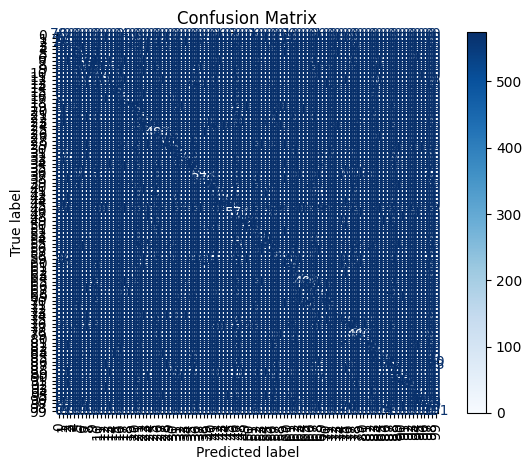

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model and tokenizer
model_path = "/content/ledgar_roberta_finetuned"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load dataset - Ensure this matches the dataset used for predictions
dataset = load_dataset("lex_glue", "ledgar")  # Use the correct dataset name
test_texts = dataset["test"]["text"]

# Get true labels and handle potential multi-label format
true_labels = dataset["test"]["label"]
# If labels are multi-label (list of lists), flatten if needed
if isinstance(true_labels[0], list):
    true_labels = [label for sublist in true_labels for label in sublist]

true_labels = np.array(true_labels)  # Convert to NumPy array

# Inference parameters
batch_size = 16
predictions = []

model.eval()
with torch.no_grad():
    for i in range(0, len(test_texts), batch_size):
        batch_texts = test_texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, truncation=True, padding=True, return_tensors="pt").to(device)
        outputs = model(**inputs)
        batch_preds = torch.argmax(outputs.logits, dim=-1)
        predictions.extend(batch_preds.cpu().numpy())

predictions = np.array(predictions)

# Evaluation
print("\n=== Classification Report ===")
print(classification_report(true_labels, predictions, digits=4))

acc = accuracy_score(true_labels, predictions)
print(f"\nAccuracy: {acc:.4f}")

for avg in ["micro", "macro", "weighted"]:
    p, r, f, _ = precision_recall_fscore_support(true_labels, predictions, average=avg)
    print(f"\n[{avg.upper()}] Precision: {p:.4f} | Recall: {r:.4f} | F1: {f:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical', cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()